<a href="https://colab.research.google.com/github/JoDeMiro/Micado-Research/blob/main/MiCADO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
%%capture
!pip install plotly
!pip install chart-studio
!pip install pyit2fls

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import chart_studio.plotly as py
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn import preprocessing

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from plotly.offline import iplot
from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import IntSlider
from ipywidgets import HTML
from ipywidgets import interact, interactive, fixed, interact_manual

import pickle
import warnings
warnings.filterwarnings('ignore')


In [12]:
#@title
from matplotlib import pyplot
from math import cos, sin, atan
from palettable.tableau import Tableau_10
from time import localtime, strftime
import numpy as np

class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius, id=-1, name=None):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)
        pyplot.gca().text(self.x, self.y-0.15, str(id), size=10, ha='center')
        if name is not None:
          pyplot.gca().text(self.x+0.05, self.y-0.5, str(name), size=20, ha='center', va='top', rotation='vertical')

class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer, input_names=None):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)
        self.input_names = input_names

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, weight=0.4, textoverlaphandler=None):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)

        # assign colors to lines depending on the sign of the weight
        color=Tableau_10.mpl_colors[0]
        if weight > 0: color=Tableau_10.mpl_colors[1]

        # assign different linewidths to lines depending on the size of the weight
        abs_weight = abs(weight)        
        if abs_weight > 0.5: 
            linewidth = 5*abs_weight
        elif abs_weight > 0.8: 
            linewidth =  50*abs_weight
        else:
            linewidth = abs_weight

        # draw the weights and adjust the labels of weights to avoid overlapping
        if abs_weight > 0.5: 
            # while loop to determine the optimal locaton for text lables to avoid overlapping
            index_step = 2
            num_segments = 10   
            txt_x_pos = neuron1.x - x_adjustment+index_step*(neuron2.x-neuron1.x+2*x_adjustment)/num_segments
            txt_y_pos = neuron1.y - y_adjustment+index_step*(neuron2.y-neuron1.y+2*y_adjustment)/num_segments
            while ((not textoverlaphandler.getspace([txt_x_pos-0.5, txt_y_pos-0.5, txt_x_pos+0.5, txt_y_pos+0.5])) and index_step < num_segments):
                index_step = index_step + 1
                txt_x_pos = neuron1.x - x_adjustment+index_step*(neuron2.x-neuron1.x+2*x_adjustment)/num_segments
                txt_y_pos = neuron1.y - y_adjustment+index_step*(neuron2.y-neuron1.y+2*y_adjustment)/num_segments

            # print("Label positions: ", "{:.2f}".format(txt_x_pos), "{:.2f}".format(txt_y_pos), "{:3.2f}".format(weight))
            a=pyplot.gca().text(txt_x_pos, txt_y_pos, "{:3.2f}".format(weight), size=12, ha='center')
            a.set_bbox(dict(facecolor='white', alpha=0))
            # print(a.get_bbox_patch().get_height())

        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment), linewidth=linewidth, color=color)
        pyplot.gca().add_line(line)

    def draw(self, layerType=0, weights=None, textoverlaphandler=None):
        j=0 # index for neurons in this layer
        z=0 # counter for names
        for neuron in self.neurons:            
            i=0 # index for neurons in previous layer
            if(layerType==0):
              name = self.input_names[z]
              neuron.draw( self.neuron_radius, id=j+1, name=name)
            else:
              neuron.draw( self.neuron_radius, id=j+1)
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, weights[i,j], textoverlaphandler)
                    i=i+1
            j=j+1
            z=z+1
        
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

# A class to handle Text Overlapping
# The idea is to first create a grid space, if a grid is already occupied, then
# the grid is not available for text labels.
class TextOverlappingHandler():
    # initialize the class with the width and height of the plot area
    def __init__(self, width, height, grid_size=0.2):
        self.grid_size = grid_size
        self.cells = np.ones((int(np.ceil(width / grid_size)), int(np.ceil(height / grid_size))), dtype=bool)

    # input test_coordinates(bottom left and top right), 
    # getspace will tell you whether a text label can be put in the test coordinates
    def getspace(self, test_coordinates):
        x_left_pos = int(np.floor(test_coordinates[0]/self.grid_size))
        y_botttom_pos = int(np.floor(test_coordinates[1]/self.grid_size))
        x_right_pos = int(np.floor(test_coordinates[2]/self.grid_size))
        y_top_pos = int(np.floor(test_coordinates[3]/self.grid_size))
        if self.cells[x_left_pos, y_botttom_pos] and self.cells[x_left_pos, y_top_pos] \
        and self.cells[x_right_pos, y_top_pos] and self.cells[x_right_pos, y_botttom_pos]:
            for i in range(x_left_pos, x_right_pos):
                for j in range(y_botttom_pos, y_top_pos):
                    self.cells[i, j] = False

            return True
        else:
            return False

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer, input_names=None):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0
        self.input_names = []
        if (input_names == None):
            self.input_names = []
        else:
            self.input_names = input_names

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer, self.input_names)
        self.layers.append(layer)

    def draw(self, weights_list=None, input_names=None):
        # vertical_distance_between_layers and horizontal_distance_between_neurons are the same with the variables of the same name in layer class
        vertical_distance_between_layers = 6
        horizontal_distance_between_neurons = 2
        overlaphandler = TextOverlappingHandler(\
            self.number_of_neurons_in_widest_layer*horizontal_distance_between_neurons,\
            len(self.layers)*vertical_distance_between_layers, grid_size=0.2 )

        if( len(self.input_names) <= 10 ):
          pyplot.figure(figsize=(12, 9))
        elif( len(self.input_names) > 10 ):
          pyplot.figure(figsize=(24, 10))
        else:
          pyplot.figure(figsize=(12,9))
        for i in range( len(self.layers) ):
            layer = self.layers[i]                                
            if i == 0:
                layer.draw( layerType=0 )
            elif i == len(self.layers)-1:
                layer.draw( layerType=-1, weights=weights_list[i-1], textoverlaphandler=overlaphandler)
            else:
                layer.draw( layerType=i, weights=weights_list[i-1], textoverlaphandler=overlaphandler)

        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        figureName='ANN_'+strftime("%Y%m%d_%H%M%S", localtime())+'.png'
        pyplot.savefig(figureName, dpi=300, bbox_inches="tight")
        pyplot.show()

class DrawNN():
    # para: neural_network is an array of the number of neurons 
    # from input layer to output layer, e.g., a neural network of 5 nerons in the input layer, 
    # 10 neurons in the hidden layer 1 and 1 neuron in the output layer is [5, 10, 1]
    # para: weights_list (optional) is the output weights list of a neural network which can be obtained via classifier.coefs_
    def __init__( self, neural_network, weights_list=None, input_names=None ):
        # self.input_names = input_names
        self.neural_network = neural_network
        self.weights_list = weights_list
        # if input_names exists
        if input_names is None:
          self.input_names = []
        else:
          self.input_names = input_names
        # if weights_list is none, then create a uniform list to fill the weights_list
        if weights_list is None:
            weights_list=[]
            for first, second in zip(neural_network, neural_network[1:]):
                tempArr = np.ones((first, second))*0.4
                weights_list.append(tempArr)
            self.weights_list = weights_list
        
    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer, self.input_names)
        for l in self.neural_network:
            network.add_layer(l)
        network.draw(self.weights_list)

In [40]:
#@title

def save_mlp(name):
  filename = name
  pickle.dump(mlp, open(filename, 'wb'))

def load_mlp(name):
  mlp = pickle.load(open(filename, 'rb'))
  return mlp

def timeline_plot(real, estimated):
  plt.figure(figsize=(20, 6))
  plt.plot(real, label = 'Real')
  plt.plot(estimated, label = 'Estimated')
  plt.title('Estimated vs Real values', fontsize=18)
  plt.ylabel('Average Latency - Normalized', fontsize=18)
  plt.xlabel('N\'th observation, time', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()

def train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test):
  fig, (a1, a2) = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
  a1.scatter(y_train, y_pred_train)
  a1.set_title('Training data', fontsize=18)
  a1.set_ylabel('Predicted', fontsize=18)
  a1.set_xlabel('Real value', fontsize=18)
  r2 = np.corrcoef(y_train.ravel(), y_pred_train.ravel())[0,1]
  a1.annotate('r2 = ' + str(round(r2, 3)), xy=(0.2, 0.8), xycoords='axes fraction', fontsize=18, ha='center', va='center')

  a2.scatter(y_test, y_pred_test)
  a2.set_title('Test data', fontsize=18)
  a2.set_ylabel('Predicted', fontsize=18)
  a2.set_xlabel('Real value', fontsize=18)
  r2 = np.corrcoef(y_test.ravel(), y_pred_test.ravel())[0,1]
  a2.annotate('r2 = ' + str(round(r2, 3)), xy=(0.2, 0.8), xycoords='axes fraction', fontsize=18, ha='center', va='center')
  plt.show()

def train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test):
  fig, (a1, a2) = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
  sns.regplot(ax=a1, x = y_train, y = y_pred_train)
  a1.set_title('Training data', fontsize=18)
  a1.set_ylabel('Predicted', fontsize=18)
  a1.set_xlabel('Real value', fontsize=18)
  a1.set_ylim(-0.05, 1.05)
  a1.set_xlim(-0.05, 1.05)
  r2 = np.corrcoef(y_train.ravel(), y_pred_train.ravel())[0,1]
  a1.annotate('r2 = ' + str(round(r2, 3)), xy=(0.2, 0.8), xycoords='axes fraction', fontsize=18, ha='center', va='center')

  sns.regplot(ax=a2, x = y_test, y = y_pred_test)
  a2.set_title('Test data', fontsize=18)
  a2.set_ylabel('Predicted', fontsize=18)
  a2.set_xlabel('Real value', fontsize=18)
  a2.set_ylim(-0.05, 1.05)
  a2.set_xlim(-0.05, 1.05)
  r2 = np.corrcoef(y_test.ravel(), y_pred_test.ravel())[0,1]
  a2.annotate('r2 = ' + str(round(r2, 3)), xy=(0.2, 0.8), xycoords='axes fraction', fontsize=18, ha='center', va='center')
  plt.show()

def cummulative_plots(errors, cummulative_errors, y_real, y_predicted):
  plt.figure(figsize=(20,4))
  plt.plot(errors, label='Error per estimation')
  plt.ylabel('Error', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()

  plt.figure(figsize=(20,4))
  plt.plot(cummulative_errors, label='Cummulative error')
  plt.ylabel('Cumulative error', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()

  plt.figure(figsize=(20,4))
  plt.plot(y_predicted, label='predicted')
  plt.plot(y_real, label='real')
  plt.ylabel('Average Latency', fontsize=18)
  plt.xlabel('N\'th observation, time', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()

def cummaulative_real_predicted_scatter(y_real, y_predicted):
  plt.figure(figsize=(10, 7))
  plt.scatter(y_real, y_predicted)
  plt.title('Estimated vas Real data', fontsize=18)
  plt.ylabel('Predicted', fontsize=18)
  plt.xlabel('Real value', fontsize=18)
  r2 = np.corrcoef(y_real, y_predicted)[0,1]
  plt.annotate('r2 = ' + str(round(r2, 3)), xy=(0.8, 0.2), xycoords='axes fraction', fontsize=18, ha='center', va='center')
  plt.show()

def cummaulative_real_predicted_scatter_sns(y_real, y_predicted):
  plt.figure(figsize=(10, 7))
  sns.regplot(x = y_real, y = y_predicted)
  plt.title('Estimated vas Real data', fontsize=18)
  plt.ylabel('Predicted', fontsize=18)
  plt.xlabel('Real value', fontsize=18)
  plt.ylim(-0.05, 1.05)
  plt.xlim(-0.05, 1.05)
  r2 = np.corrcoef(y_real, y_predicted)[0,1]
  plt.annotate('r2 = ' + str(round(r2, 3)), xy=(0.8, 0.2), xycoords='axes fraction', fontsize=18, ha='center', va='center')
  plt.show()

def timeline(variable):
  plt.figure(figsize=(20,4))
  plt.plot(variable, label='Timeseries')
  plt.ylabel('Value', fontsize=18)
  plt.legend(fontsize=14, frameon=False)
  plt.show()


In [4]:
!wget https://github.com/JoDeMiro/Data/raw/main/Micado/nn_training_data_2777.csv

--2021-06-25 20:57:49--  https://github.com/JoDeMiro/Data/raw/main/Micado/nn_training_data_2777.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JoDeMiro/Data/main/Micado/nn_training_data_2777.csv [following]
--2021-06-25 20:57:49--  https://raw.githubusercontent.com/JoDeMiro/Data/main/Micado/nn_training_data_2777.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 536472 (524K) [text/plain]
Saving to: ‘nn_training_data_2777.csv’

nn_training_data_27 100%[===================>] 523.90K  --.-KB/s    in 0.01s   

2021-06-25 20:57:50 (43.8 MB/s) - ‘nn_training_data_2777.csv’ saved [536472/536472]

In [6]:
df = pd.read_csv('nn_training_data_pk_hosszu_clean-roviditett.csv')

In [8]:
df.head()

timestamp     PktIn      KBIn  ...    PktOut  vm_number    AVG_LAT_05
0  1565842767  0.266626  0.026494  ...  0.199977          3  12740.186333
1  1565842808  0.283311  0.027179  ...  0.199987          3  13139.585667
2  1565842838  0.249975  0.025420  ...  0.249958          3  12802.591667
3  1565842870  0.199973  0.022588  ...  0.199973          3  12740.186333
4  1565842902  0.266710  0.026501  ...  0.233363          4  12997.365333

[5 rows x 12 columns]

In [9]:
# gyors testzek a változókra

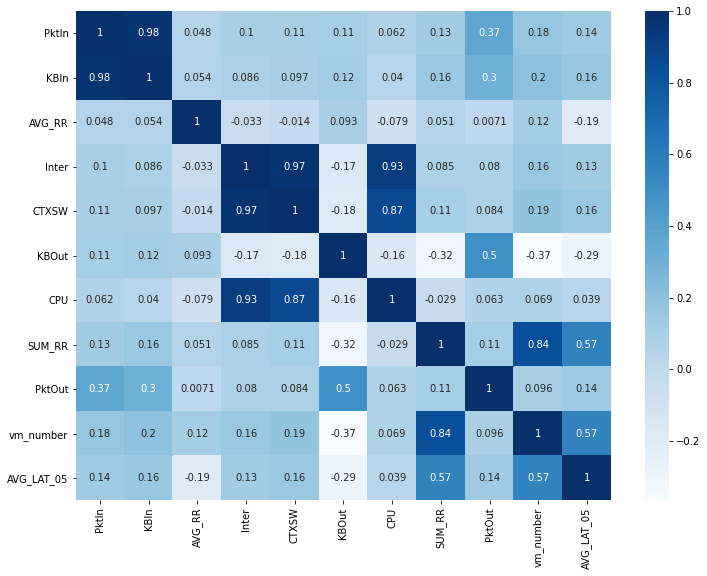

In [10]:
# korrelácó az egyes változók között
corr = df.iloc[: , 1:].corr()

plt.figure(figsize=(12,9))
sns.heatmap(corr, cmap="Blues", annot=True)
# plt.savefig('correlation_matrix.png')
plt.show()


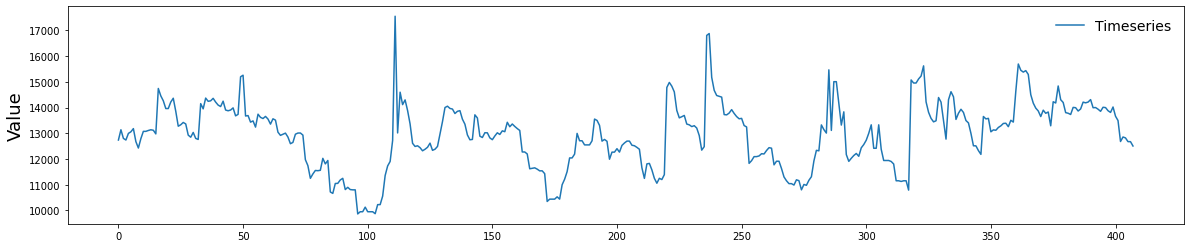

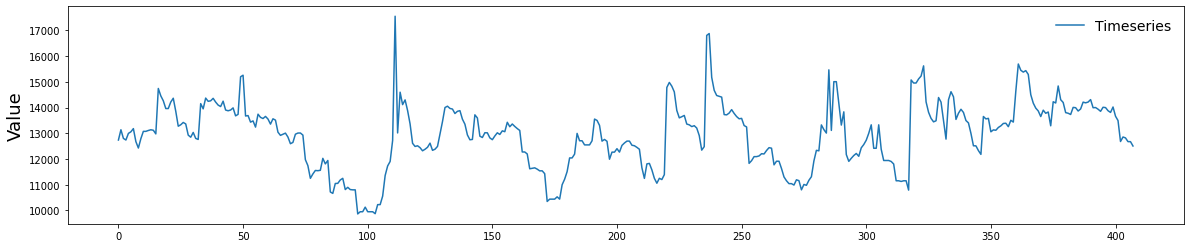

In [15]:
timeline(df['AVG_LAT_05'])

df = df[df['AVG_LAT_05'] < 20000]

timeline(df['AVG_LAT_05'])


In [16]:
# Keressük meg azokat az adatokat ahol változott a gépek száma

In [17]:
def createBeforeafterDF(df, lag, inputMetrics):
    beforeafterDF = df.copy()
    length = len(inputMetrics)
    # print(length)
    inputVariables = np.flip(beforeafterDF.columns[0:length].ravel(), axis=-1)
    # print('Input Variablels : ', inputVariables)

    index = length
    for i in inputVariables:
        new_column = beforeafterDF[i].shift(lag)
        new_column_name = (i + str(1)) # Todo: rename str(lag)
        beforeafterDF.insert(loc=index, column=new_column_name, value=new_column)

    beforeafterDF = beforeafterDF[lag:]

    return beforeafterDF

# Fontos
metrics = df.columns

# Before After adatok egy sorban
ba = createBeforeafterDF(df, 1, metrics)

# Csak azok az adatok ahol tényleges eltérés volt a gépek száma között
def createScalingDF(theBeforeAfterDF):
  new_beforeafterDF = theBeforeAfterDF.copy()
  scalingDF = new_beforeafterDF[new_beforeafterDF.vm_number != new_beforeafterDF.vm_number1]
  return scalingDF

fd = createScalingDF(ba)

rossz = fd.copy()

# Ki kell szűrni azokat az eseteket, ahol egynél több gépet adott hozzá, vagy vett el
fd['difference'] = fd['vm_number']-fd['vm_number1']
fd['abs_difference'] = abs(fd['difference'])
fd = fd[fd['abs_difference'] < 2]

print(fd.shape)

(22, 26)


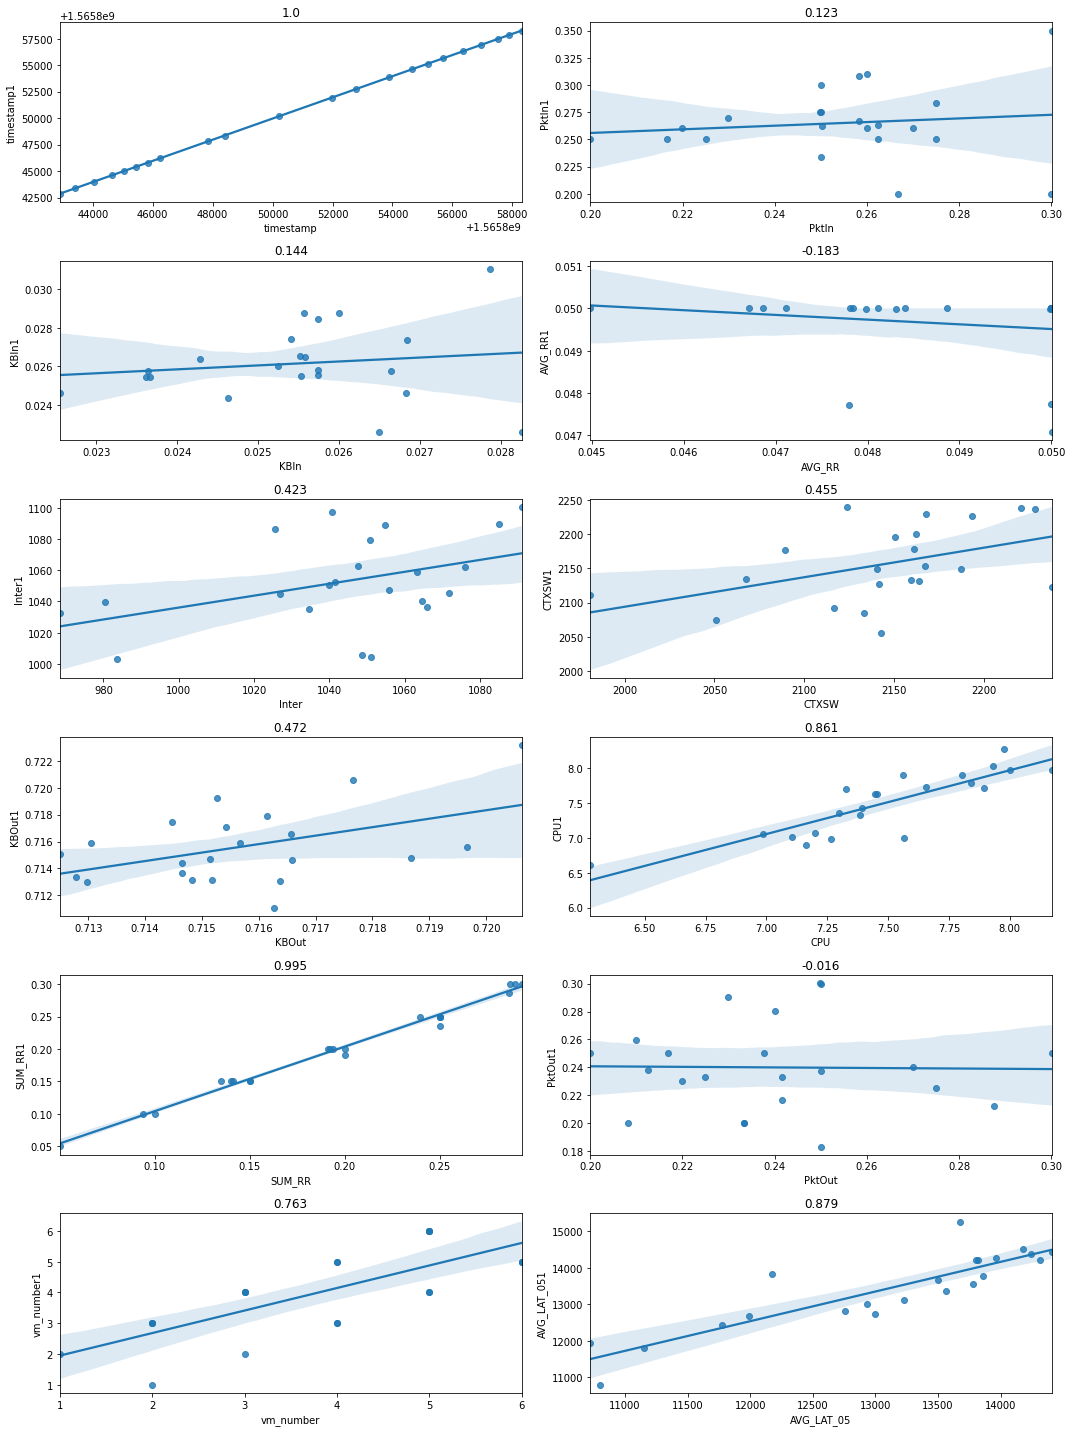

In [18]:
# Most nézzük meg, hogy milyen korreláció van az egyes before after változók között

fig, axes = plt.subplots(6, 2, figsize=(15, 20), sharey=False)
for j, i in enumerate(df.columns):
  corr = str(round(fd[i].corr(fd[i+'1']), 3))

  r = int(j/2)
  c = 1 if (j % 2 == 1) else 0
  sns.regplot(ax=axes[r, c], x = fd[i], y = fd[i+'1']).set_title(corr)

plt.tight_layout()
plt.show()


r2  =  0.7421338819040775
r2w =  0.7421338819040775


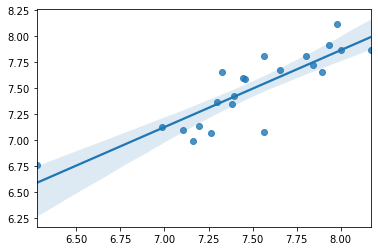

In [19]:
# Regresszió

y = fd['CPU'].values          # Current
x = fd['CPU1'].values         # Lag
x = x.reshape(-1,1)
x1 = fd[['CPU1', 'CTXSW1']].values
# még a vm számmal kell kipróbálni, kíváncsi vagyok az javít vagy ront-e a helyzeten


regression = LinearRegression()

regression.fit(x,y)

y_pred = regression.predict(x)

r2  = r2_score(y, y_pred)
r2w = r2_score(y, y_pred, multioutput='variance_weighted')

print('r2  = ', r2)
print('r2w = ', r2w)

sns.regplot(y, y_pred)
plt.show()

In [20]:
fd.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05', 'timestamp1',
       'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051', 'difference',
       'abs_difference'],
      dtype='object')

r2_old  =  0.754076860885141 	 r2w_old =  0.754076860885141
r2_new  =  0.8029089922264503 	 r2w_new =  0.8029089922264503


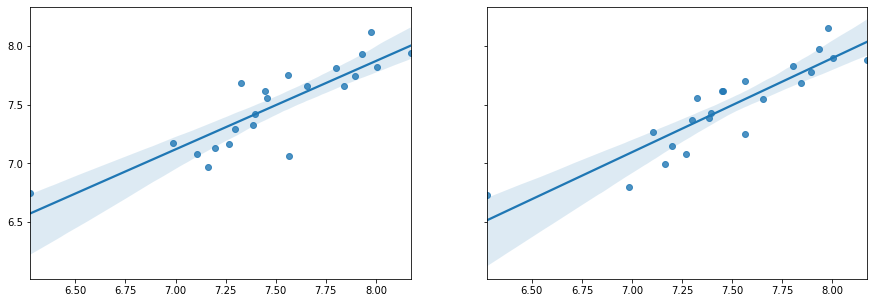

In [21]:
# Regresszió

y     = fd['CPU'].values          # Current
x_old = fd[['CPU1', 'vm_number1']].values
x_new = fd[['CPU1', 'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'KBOut1', 'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051']].values

x_new = fd[['CPU1', 'PktIn1']].values

regression = LinearRegression()

# fit old
regression.fit(x_old, y)
y_pred_old = regression.predict(x_old)
r2_old  = r2_score(y, y_pred_old)
r2w_old = r2_score(y, y_pred_old, multioutput='variance_weighted')

# fit new
regression.fit(x_new, y)
y_pred_new = regression.predict(x_new)
r2_new  = r2_score(y, y_pred_new)
r2w_new = r2_score(y, y_pred_new, multioutput='variance_weighted')


print('r2_old  = ', r2_old, '\t', 'r2w_old = ', r2w_old)
print('r2_new  = ', r2_new, '\t', 'r2w_new = ', r2w_new)


fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.regplot(ax=axes[0], x = y, y = y_pred_old)
sns.regplot(ax=axes[1], x = y, y = y_pred_new)
plt.show()


timestamp
r2_old  =  0.08203509427151867 	 r2w_old =  0.08203509427151867
r2_lat  =  0.537649671822559 	 r2w_lat =  0.537649671822559
r2_new  =  0.6536190797671109 	 r2w_new =  0.6536190797671109


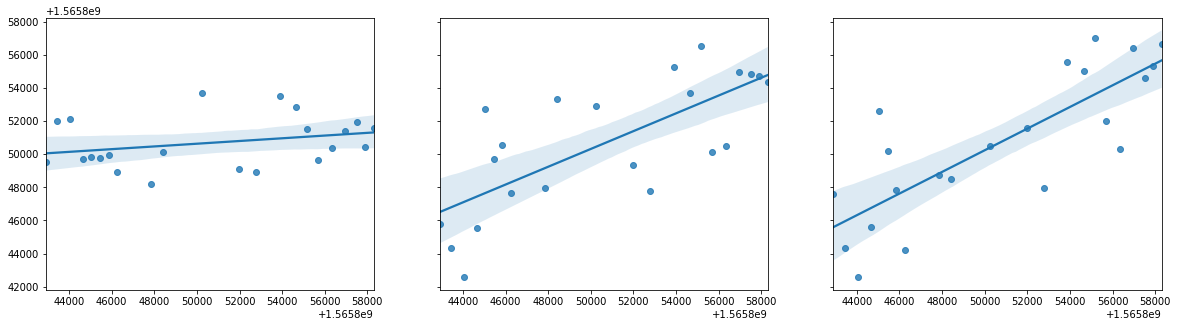

PktIn
r2_old  =  0.05581959853294427 	 r2w_old =  0.05581959853294427
r2_lat  =  0.6427113270628164 	 r2w_lat =  0.6427113270628164
r2_new  =  0.6542564646393307 	 r2w_new =  0.6542564646393308


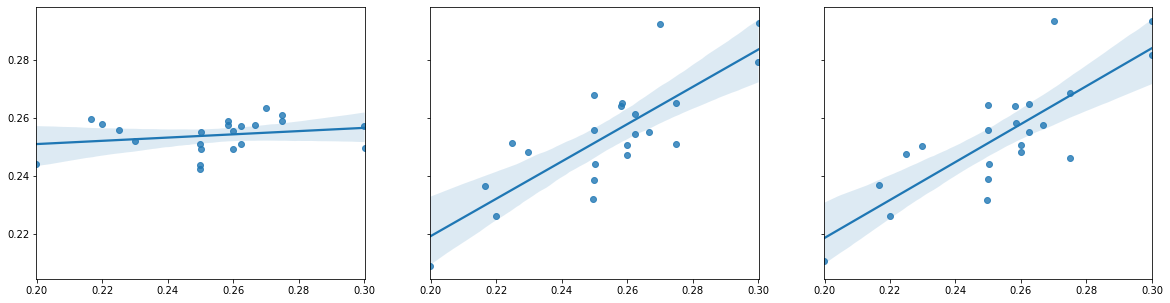

KBIn
r2_old  =  0.08350845731872125 	 r2w_old =  0.08350845731872125
r2_lat  =  0.5872851286604219 	 r2w_lat =  0.5872851286604219
r2_new  =  0.6179035428664243 	 r2w_new =  0.6179035428664243


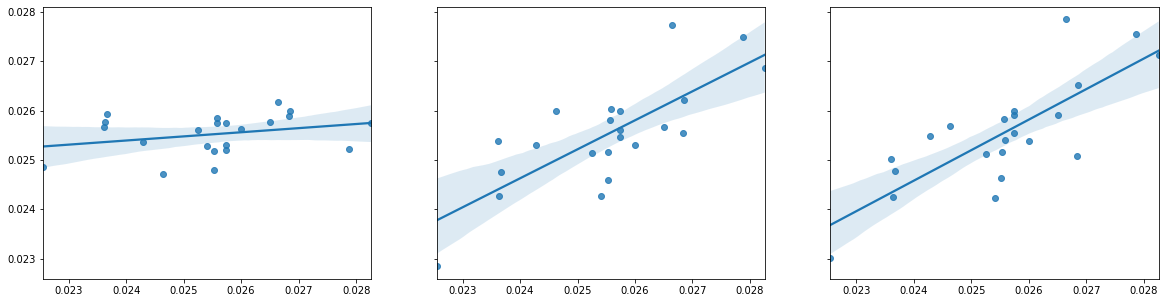

AVG_RR
r2_old  =  0.005943513794573585 	 r2w_old =  0.005943513794573585
r2_lat  =  0.22329215411385428 	 r2w_lat =  0.22329215411385428
r2_new  =  0.5552710033246255 	 r2w_new =  0.5552710033246255


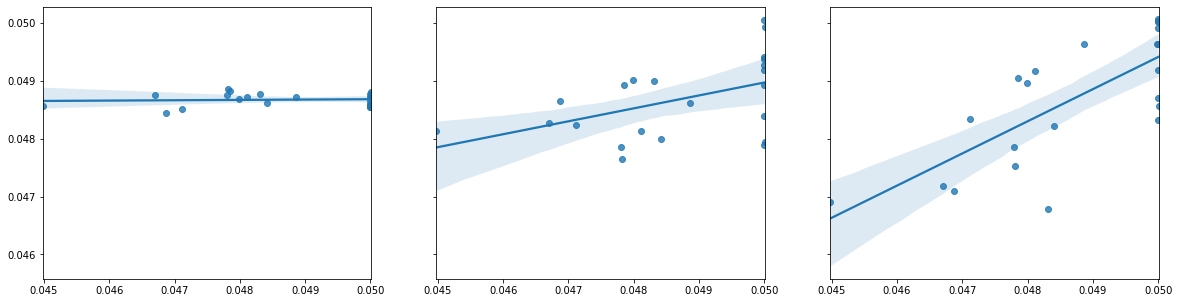

Inter
r2_old  =  0.4403276325547172 	 r2w_old =  0.4403276325547172
r2_lat  =  0.7401632192288566 	 r2w_lat =  0.7401632192288566
r2_new  =  0.7651220924772297 	 r2w_new =  0.7651220924772297


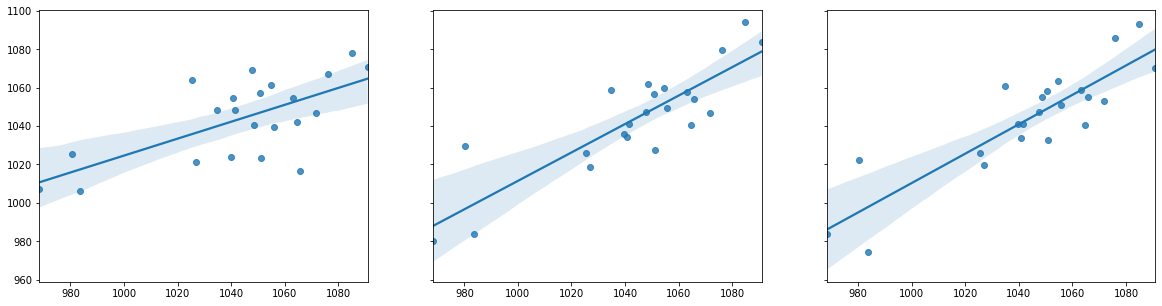

CTXSW
r2_old  =  0.3278599007090447 	 r2w_old =  0.3278599007090447
r2_lat  =  0.8632317409827946 	 r2w_lat =  0.8632317409827946
r2_new  =  0.8727942195274931 	 r2w_new =  0.8727942195274931


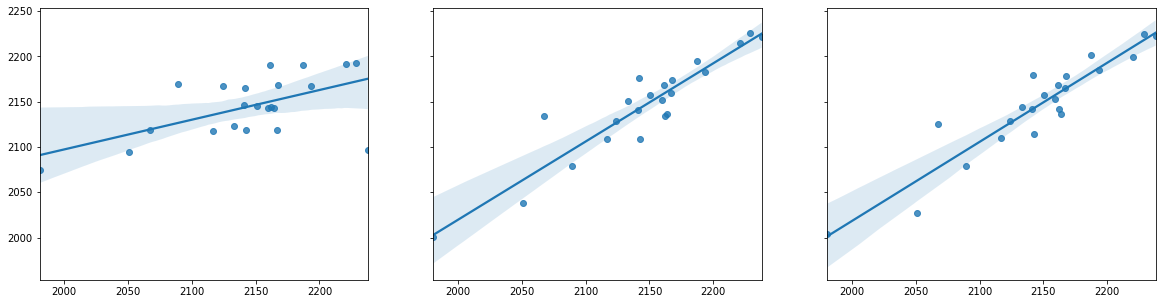

KBOut
r2_old  =  0.3913537053247943 	 r2w_old =  0.3913537053247943
r2_lat  =  0.6843383220345107 	 r2w_lat =  0.6843383220345106
r2_new  =  0.6880025151743792 	 r2w_new =  0.6880025151743792


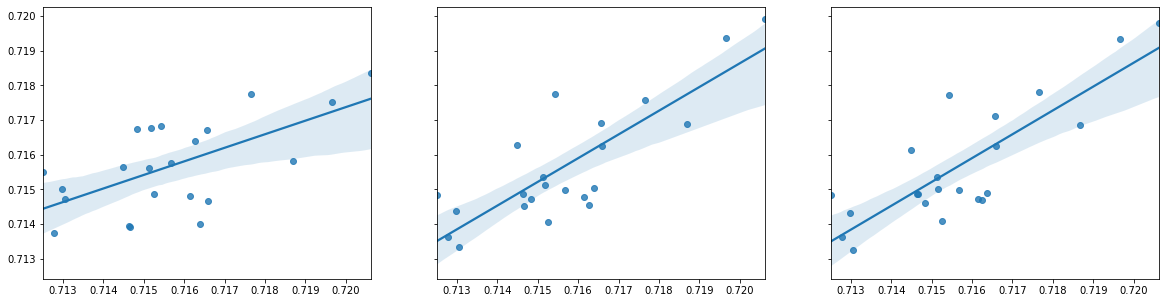

CPU
r2_old  =  0.754076860885141 	 r2w_old =  0.754076860885141
r2_lat  =  0.9155989660154185 	 r2w_lat =  0.9155989660154185
r2_new  =  0.9228124997348809 	 r2w_new =  0.9228124997348809


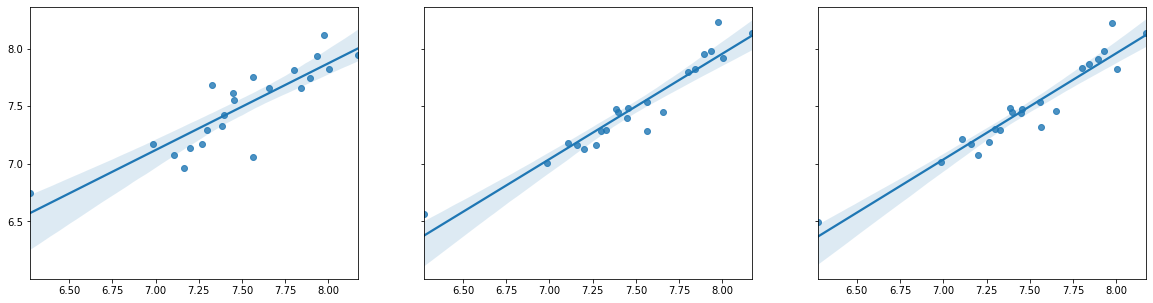

SUM_RR
r2_old  =  0.9946110915235322 	 r2w_old =  0.9946110915235322
r2_lat  =  0.9966485513739604 	 r2w_lat =  0.9966485513739605
r2_new  =  0.9979973623090623 	 r2w_new =  0.9979973623090623


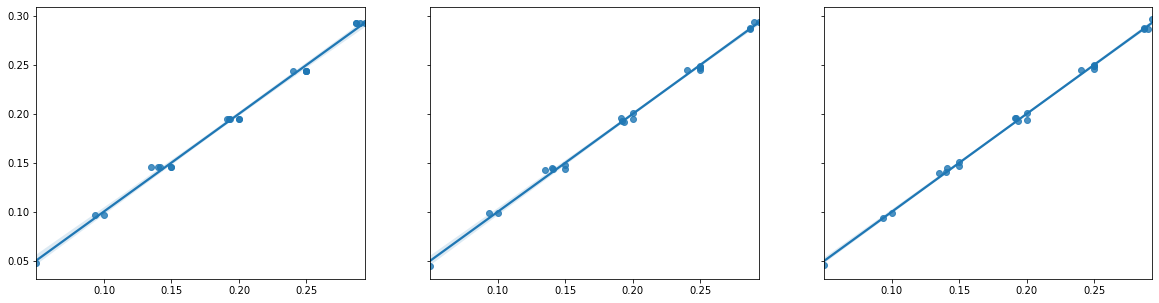

PktOut
r2_old  =  0.040829294786298154 	 r2w_old =  0.040829294786298154
r2_lat  =  0.5096467377189882 	 r2w_lat =  0.5096467377189882
r2_new  =  0.5107555671211279 	 r2w_new =  0.5107555671211279


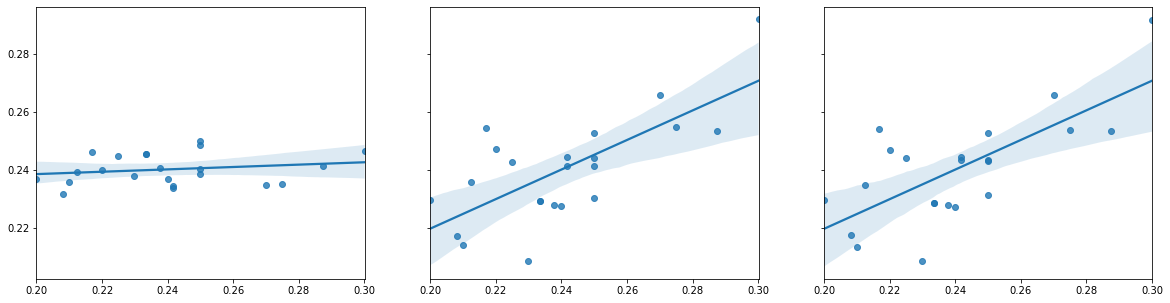

vm_number
r2_old  =  0.5829772441808717 	 r2w_old =  0.5829772441808717
r2_lat  =  0.7332207310255261 	 r2w_lat =  0.7332207310255261
r2_new  =  0.8027931683820007 	 r2w_new =  0.8027931683820005


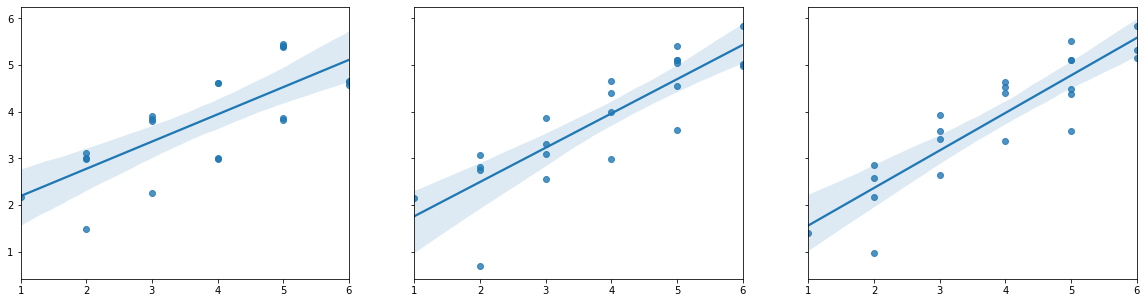

AVG_LAT_05
r2_old  =  0.42178621607234934 	 r2w_old =  0.4217862160723493
r2_lat  =  0.6257576570545074 	 r2w_lat =  0.6257576570545075
r2_new  =  0.8989162222467212 	 r2w_new =  0.8989162222467211


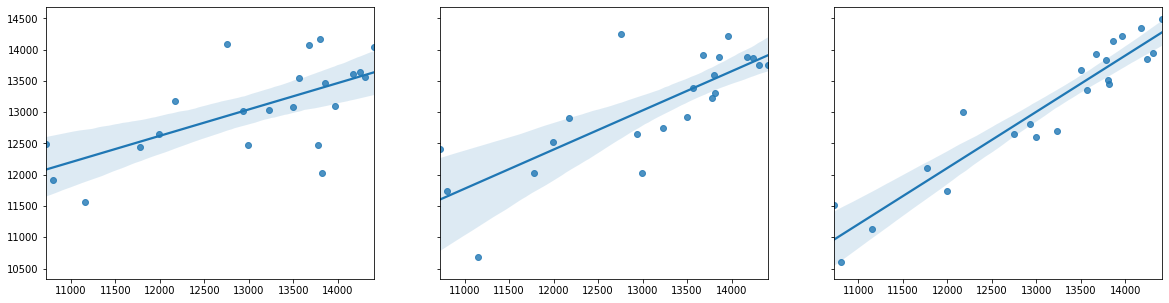

In [22]:
# Regresszió
for i in df.columns:
  y     = fd[i].values               # Current
  x_old = fd[['CPU1', 'vm_number1']].values
  x_new = fd[['CPU1', 'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'KBOut1', 'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051']].values
  x_lat = fd[['CPU1', 'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'KBOut1', 'SUM_RR1', 'PktOut1', 'vm_number1']].values


  regression = LinearRegression()

  # fit old
  regression.fit(x_old, y)
  y_pred_old = regression.predict(x_old)
  r2_old  = r2_score(y, y_pred_old)
  r2w_old = r2_score(y, y_pred_old, multioutput='variance_weighted')

  # fit new
  regression.fit(x_new, y)
  y_pred_new = regression.predict(x_new)
  r2_new  = r2_score(y, y_pred_new)
  r2w_new = r2_score(y, y_pred_new, multioutput='variance_weighted')

  # fit without latency
  regression.fit(x_lat, y)
  y_pred_lat = regression.predict(x_lat)
  r2_lat  = r2_score(y, y_pred_lat)
  r2w_lat = r2_score(y, y_pred_lat, multioutput='variance_weighted')



  print(i)
  print('r2_old  = ', r2_old, '\t', 'r2w_old = ', r2w_old)
  print('r2_lat  = ', r2_lat, '\t', 'r2w_lat = ', r2w_lat)
  print('r2_new  = ', r2_new, '\t', 'r2w_new = ', r2w_new)


  fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
  sns.regplot(ax=axes[0], x = y, y = y_pred_old)
  sns.regplot(ax=axes[1], x = y, y = y_pred_lat)
  sns.regplot(ax=axes[2], x = y, y = y_pred_new)
  # plt.savefig('before_after.png')
  plt.show()
  


In [25]:
# NN, a request rate nélkül

In [26]:
df.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05'],
      dtype='object')

In [27]:
columns = ['PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']

X = df[columns].values
y = df['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'relu'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=(4,),
                           max_iter=500,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           # n_iter_no_change=20, \
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.7636959801145824
r2 test  =  0.6329399160911533


In [43]:
save_mlp('1_model.sav')

In [45]:
mlp = load_mlp('1_model.sav')

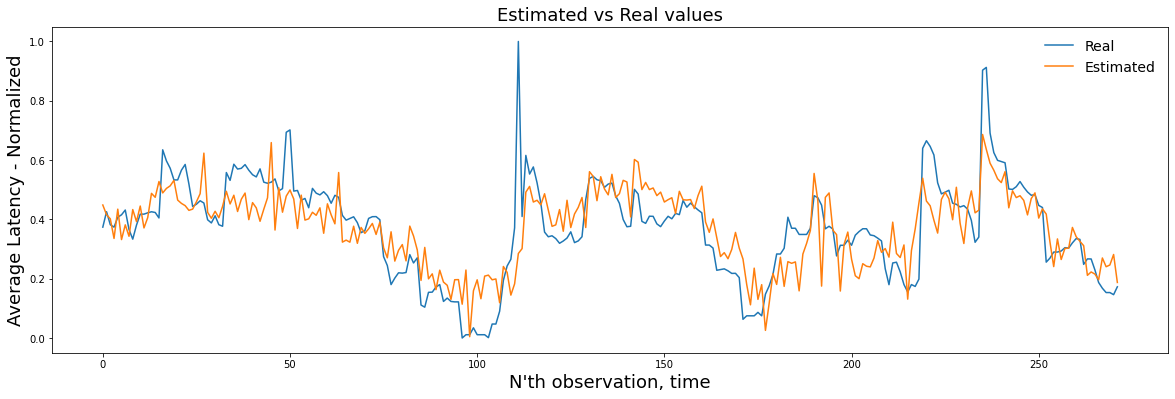

In [46]:
timeline_plot(y_train, y_pred_train)

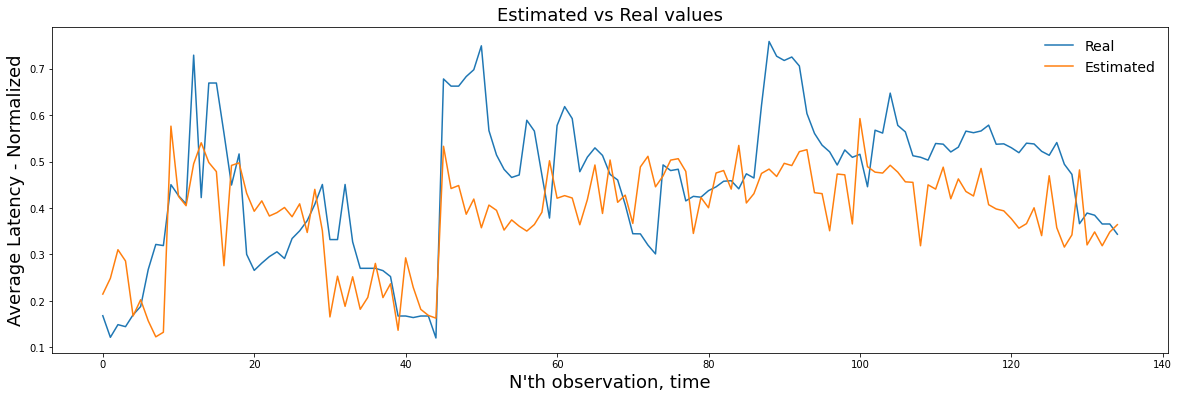

In [33]:
timeline_plot(y_test, y_pred_test)

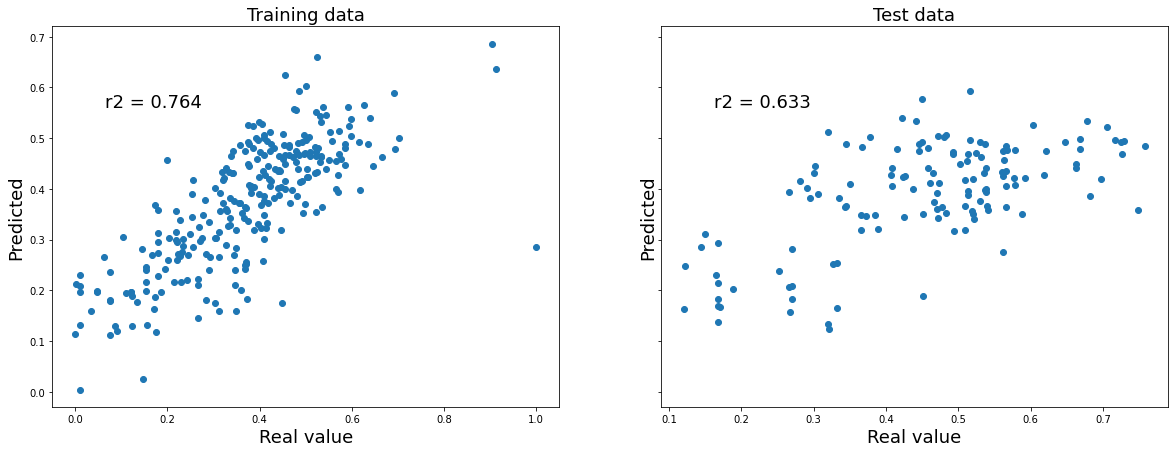

In [34]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

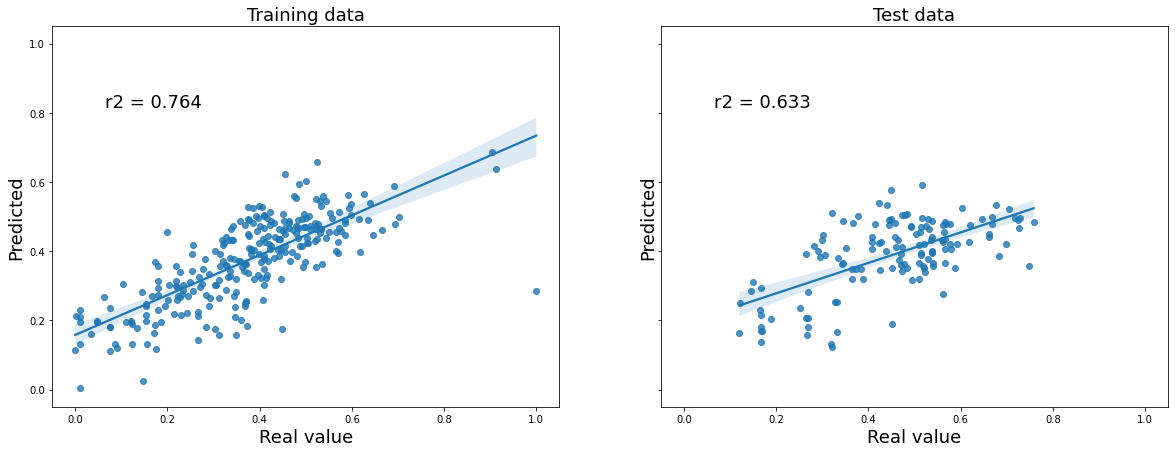

In [35]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

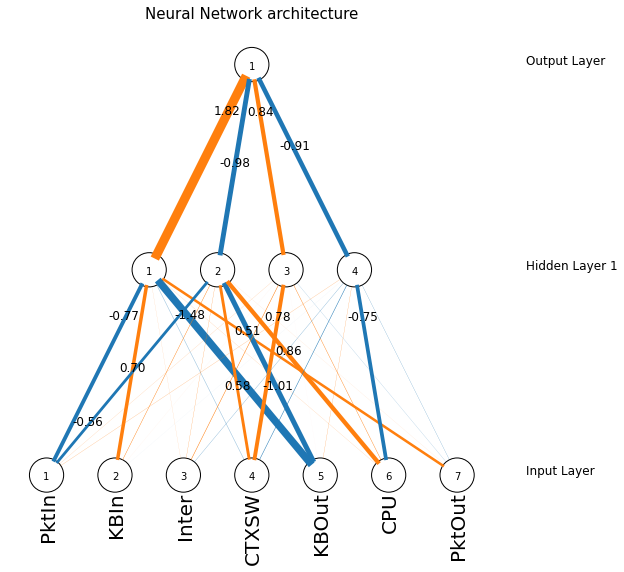

In [47]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

In [48]:
# NN request rate nélkül laggal

In [49]:
ba.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05', 'timestamp1',
       'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051'],
      dtype='object')

In [50]:
columns = ['PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut',
           'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1', 'PktOut1']

X = ba[columns].values
y = ba['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'relu'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=4,
                           max_iter=500,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           # n_iter_no_change=20, \
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.8072445874807793
r2 test  =  0.6426889375415011


In [54]:
model = '2_model.sav'
if (load == True):
  mlp = load_mplp(model)
else:
  save_mlp(model)

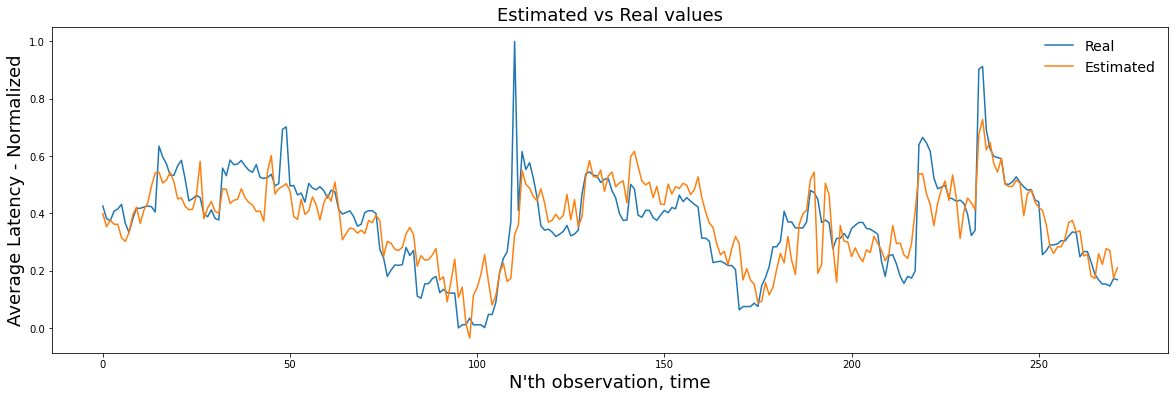

In [55]:
timeline_plot(y_train, y_pred_train)

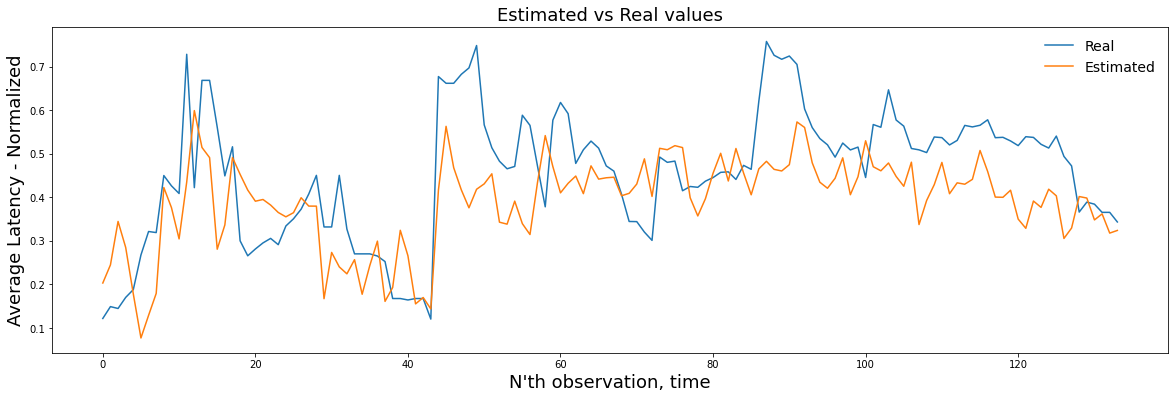

In [56]:
timeline_plot(y_test, y_pred_test)

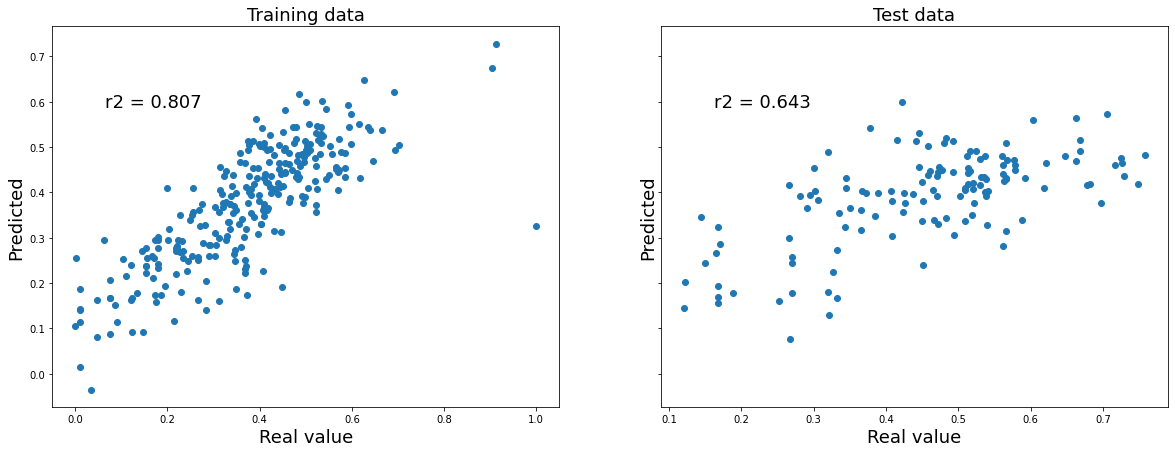

In [57]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

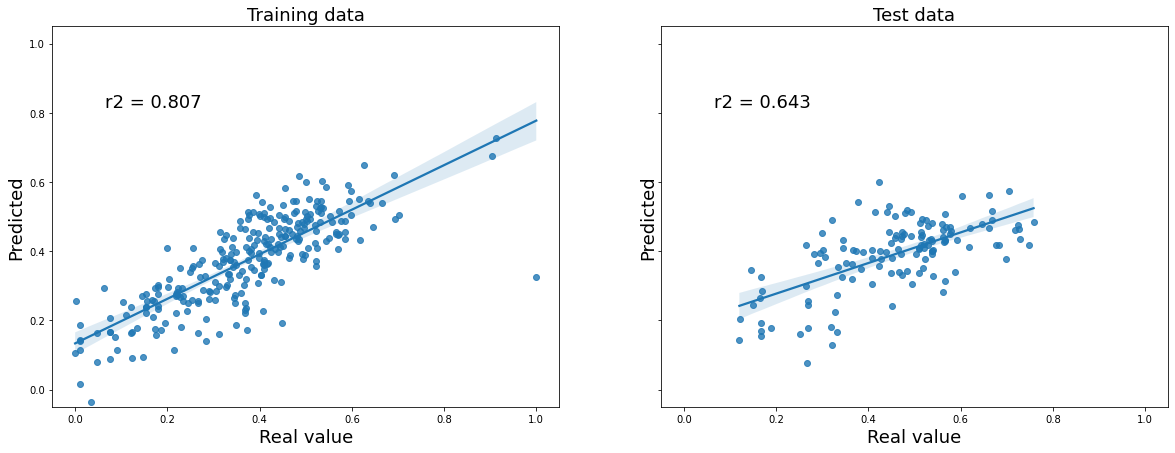

In [58]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

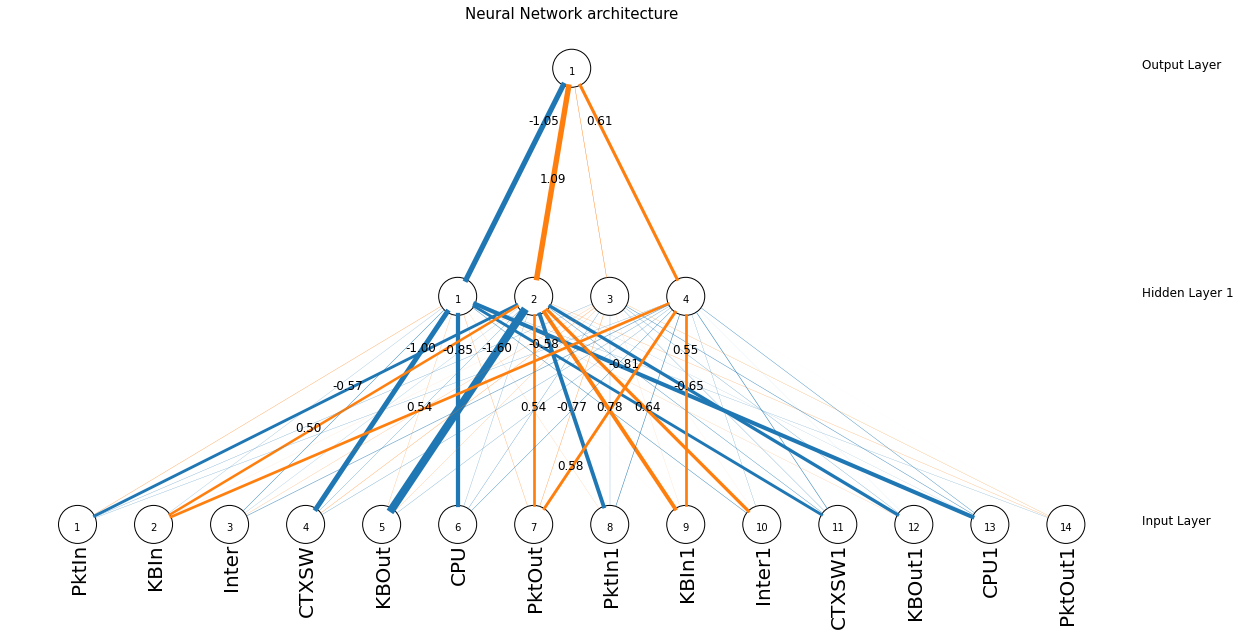

In [59]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

In [60]:
# NN request rate nélkül laggal összetettem neurális hálóval

In [61]:
ba.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05', 'timestamp1',
       'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051'],
      dtype='object')

In [62]:
columns = ['PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut',
           'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1', 'PktOut1']

X = ba[columns].values
y = ba['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'tanh'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=(10,4),
                           max_iter=500,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           # n_iter_no_change=20, \
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.8560525528487342
r2 test  =  0.6479864451260952


In [63]:
model = '3_model.sav'
if (load == True):
  mlp = load_mplp(model)
else:
  save_mlp(model)

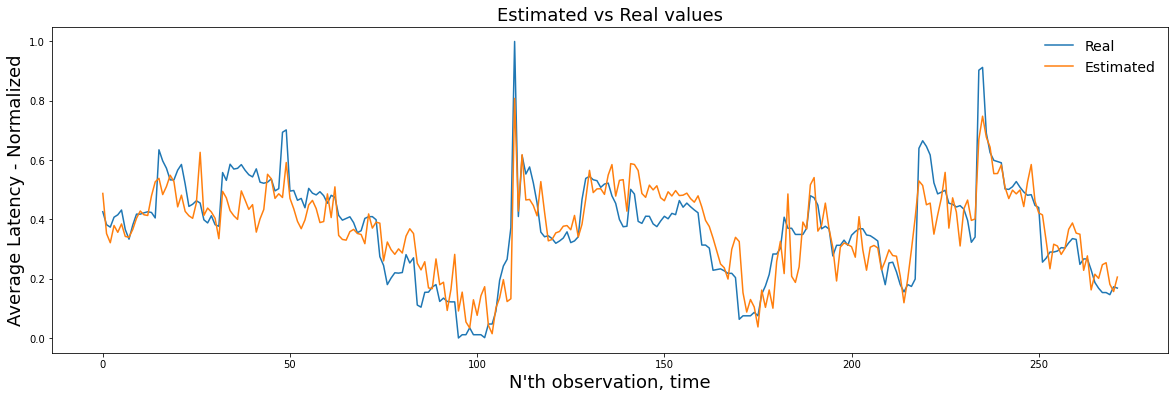

In [64]:
timeline_plot(y_train, y_pred_train)

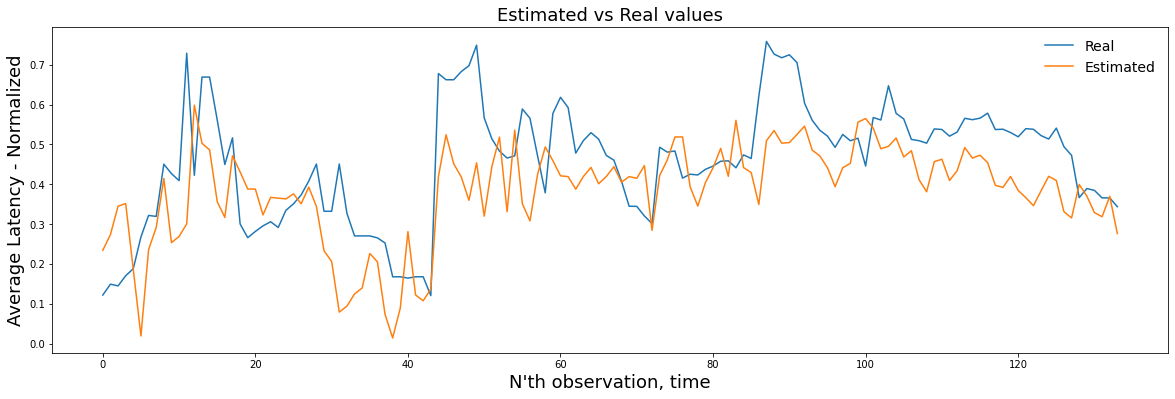

In [65]:
timeline_plot(y_test, y_pred_test)

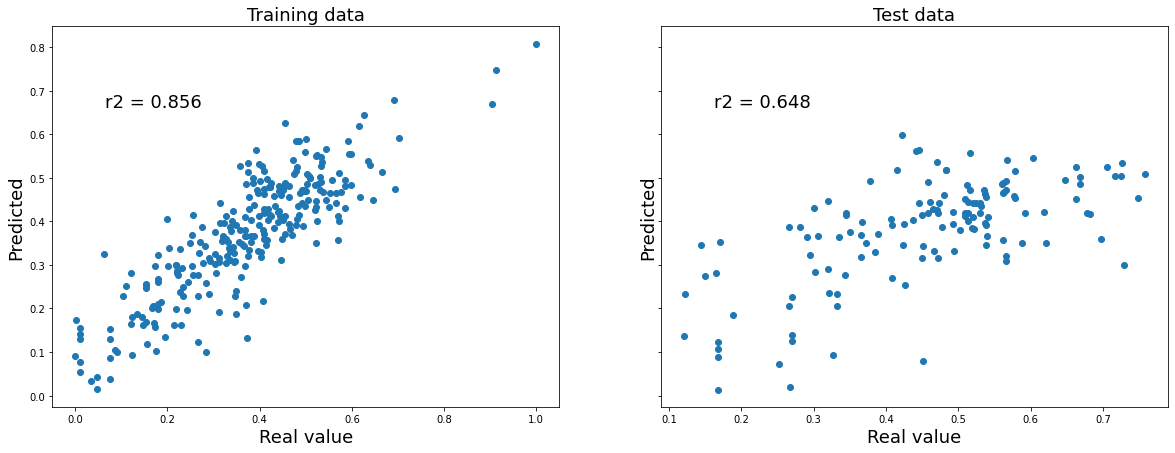

In [66]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

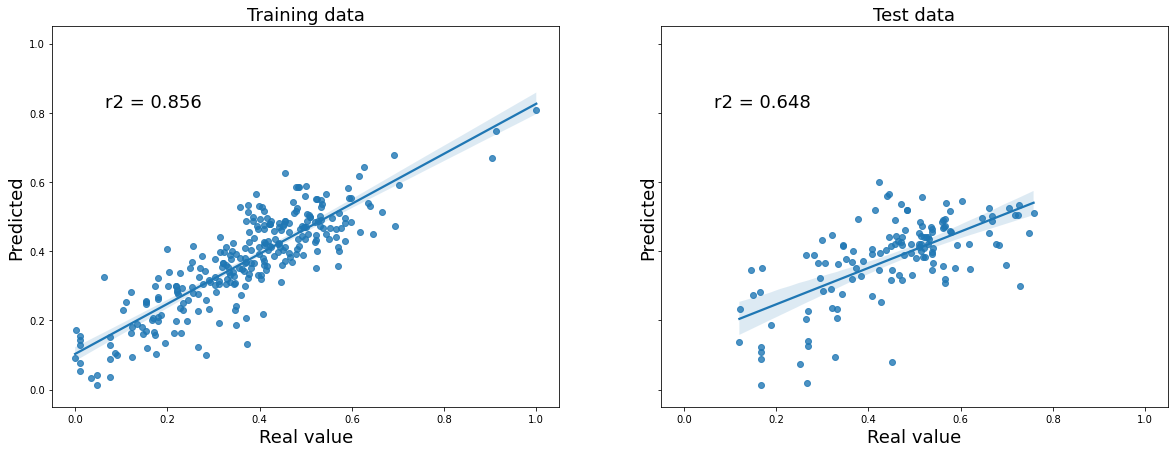

In [67]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

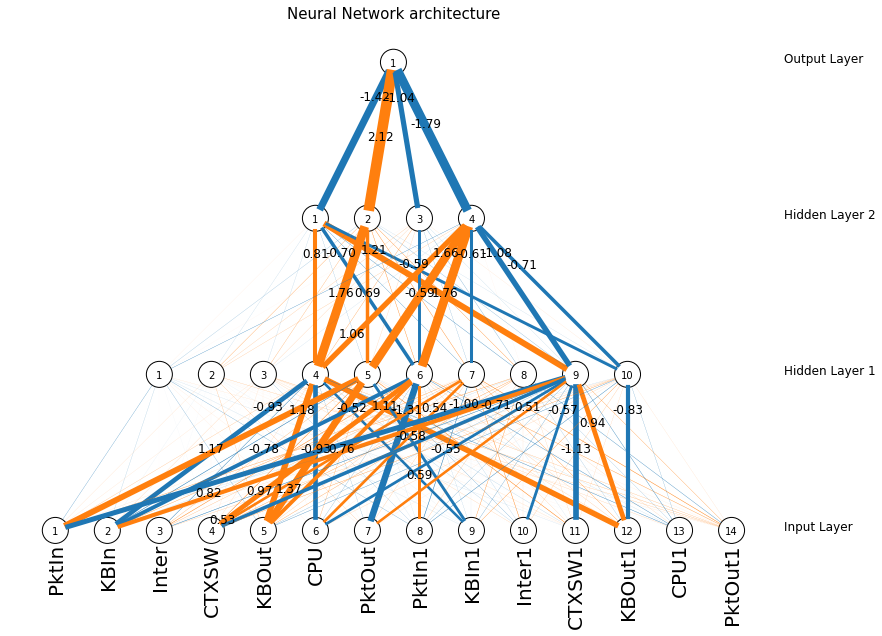

In [68]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

In [69]:
# NN, lag nélkül és laggal

In [70]:
df.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05'],
      dtype='object')

In [71]:
columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']

X = df[columns].values
y = df['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'relu'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=(10,4),
                           max_iter=500,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           # n_iter_no_change=20, \
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.8701441728634379
r2 test  =  0.5830658711085674


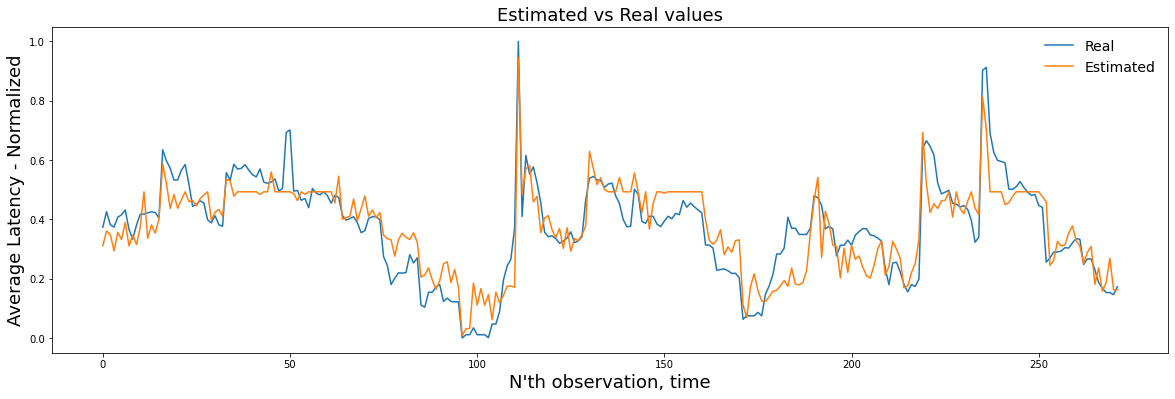

In [72]:
timeline_plot(y_train, y_pred_train)

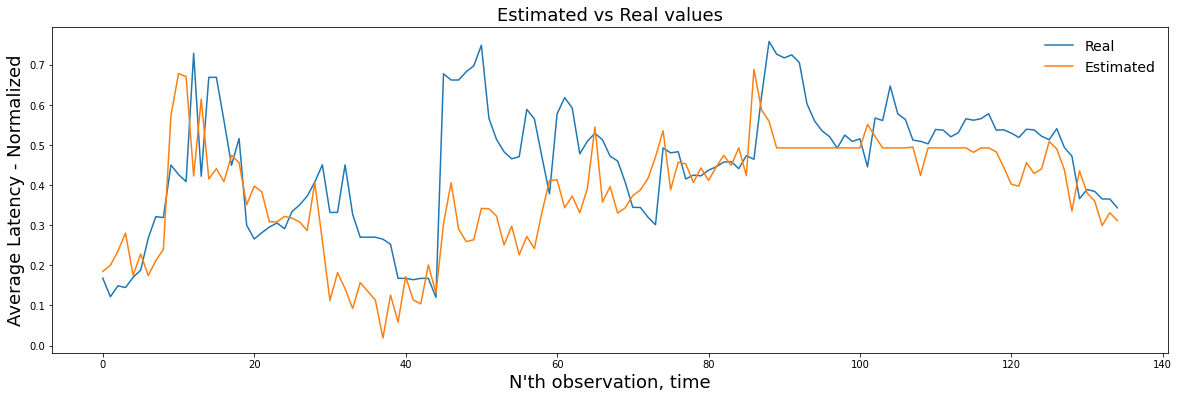

In [73]:
timeline_plot(y_test, y_pred_test)

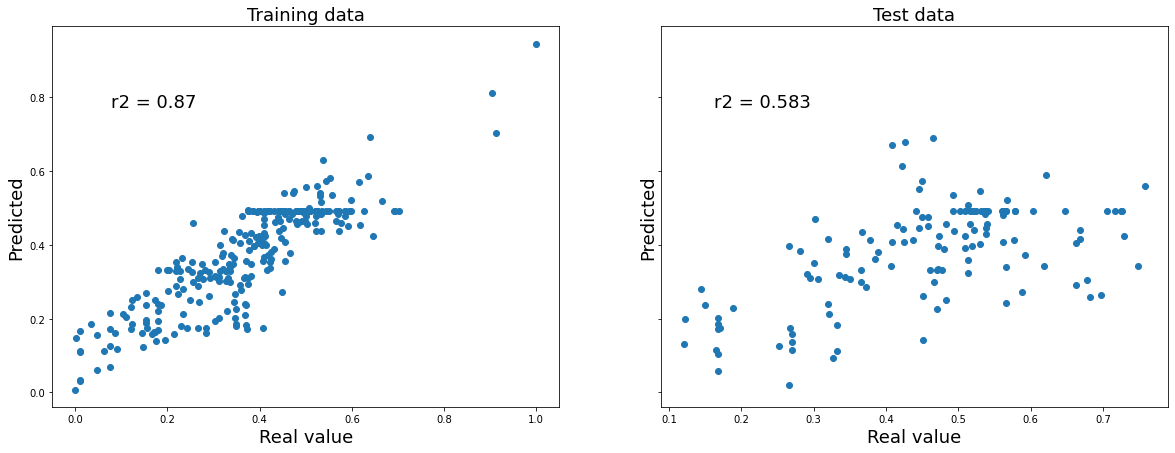

In [74]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

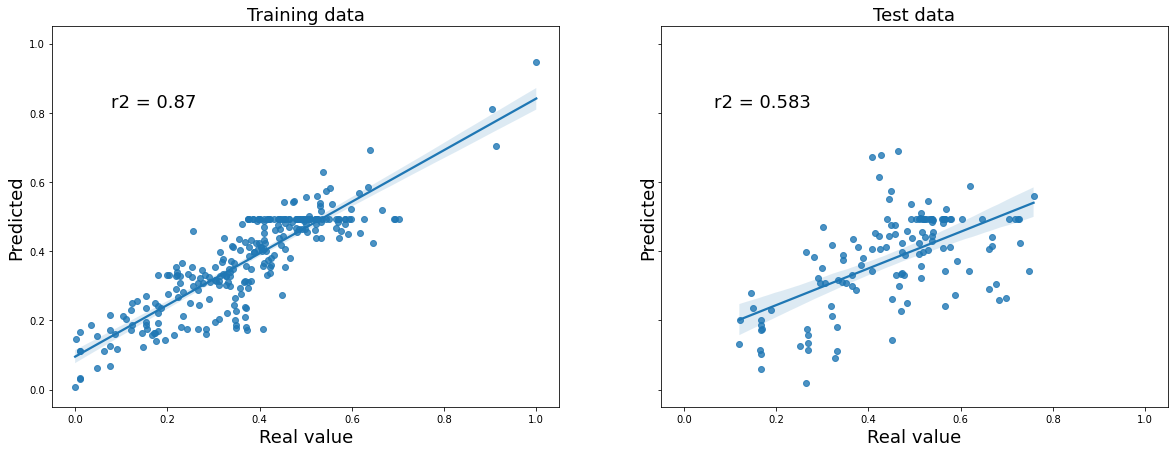

In [75]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

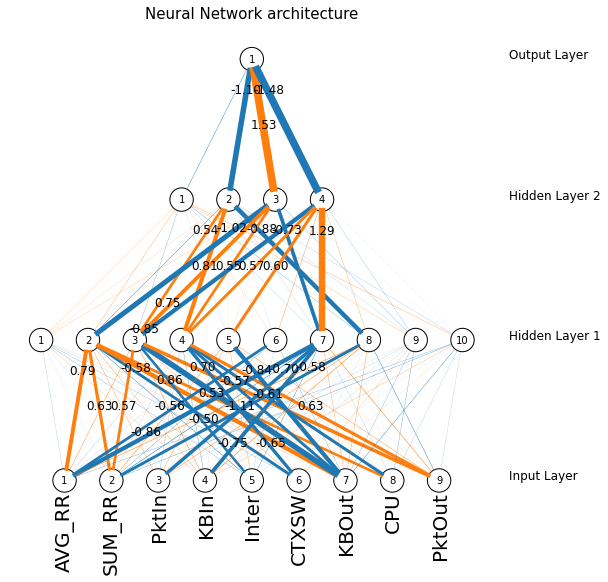

In [76]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

In [77]:
# NN laggal

In [78]:
ba.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05', 'timestamp1',
       'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051'],
      dtype='object')

In [79]:
columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut', 'AVG_RR1', 'SUM_RR1', 'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'PktOut1']

X = ba[columns].values
y = ba['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'relu'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=4,
                           max_iter=500,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           # n_iter_no_change=20, \
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.8216792810035435
r2 test  =  0.6396158213829503


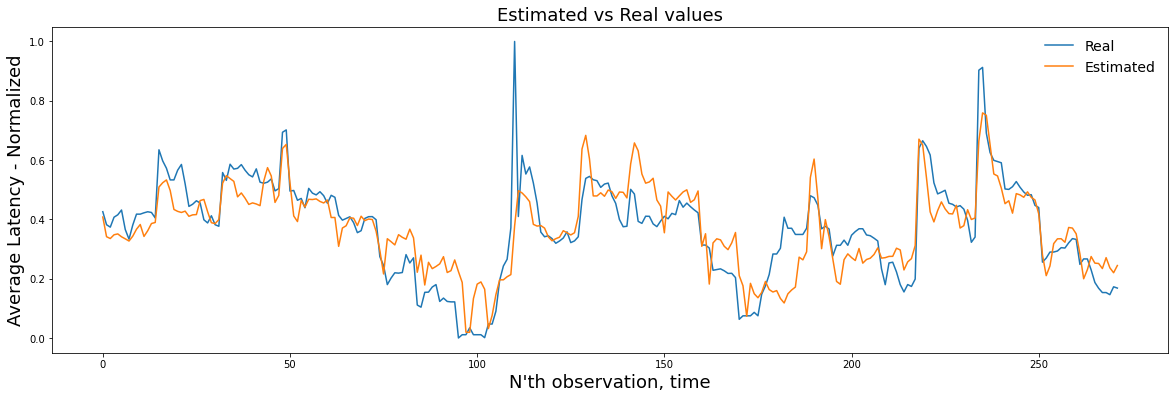

In [80]:
timeline_plot(y_train, y_pred_train)

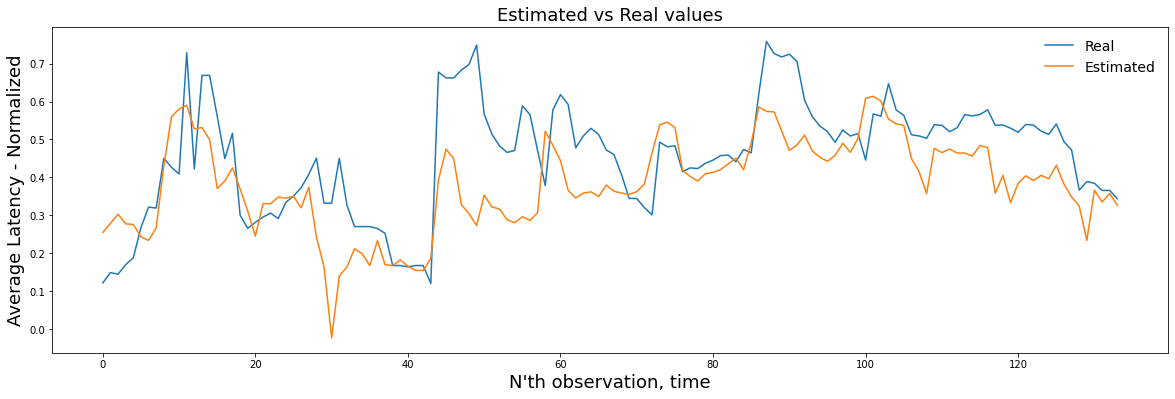

In [81]:
timeline_plot(y_test, y_pred_test)

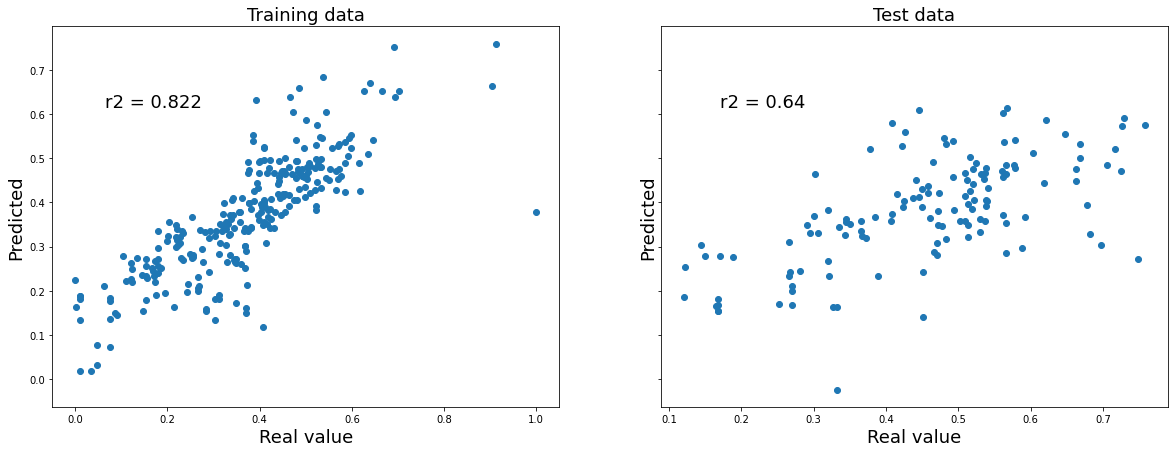

In [82]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

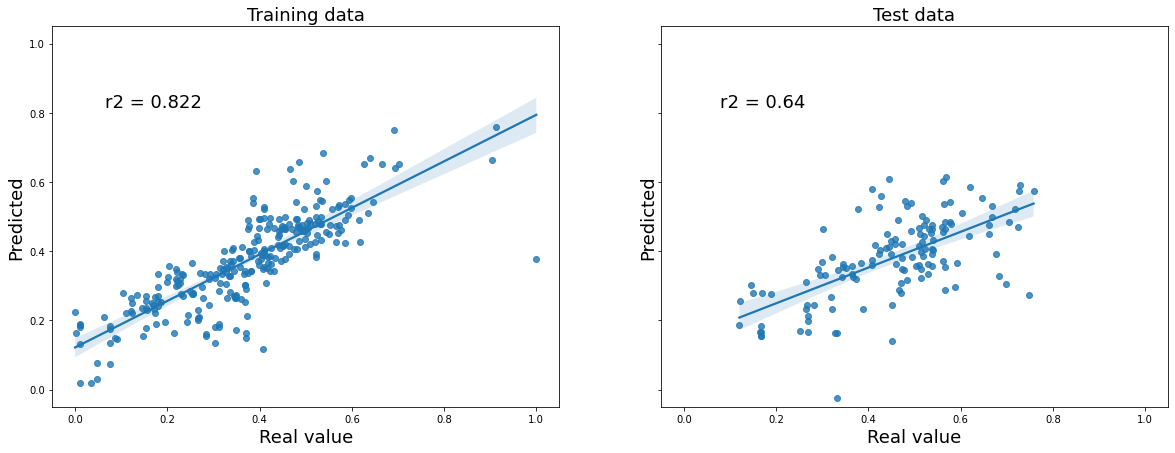

In [83]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

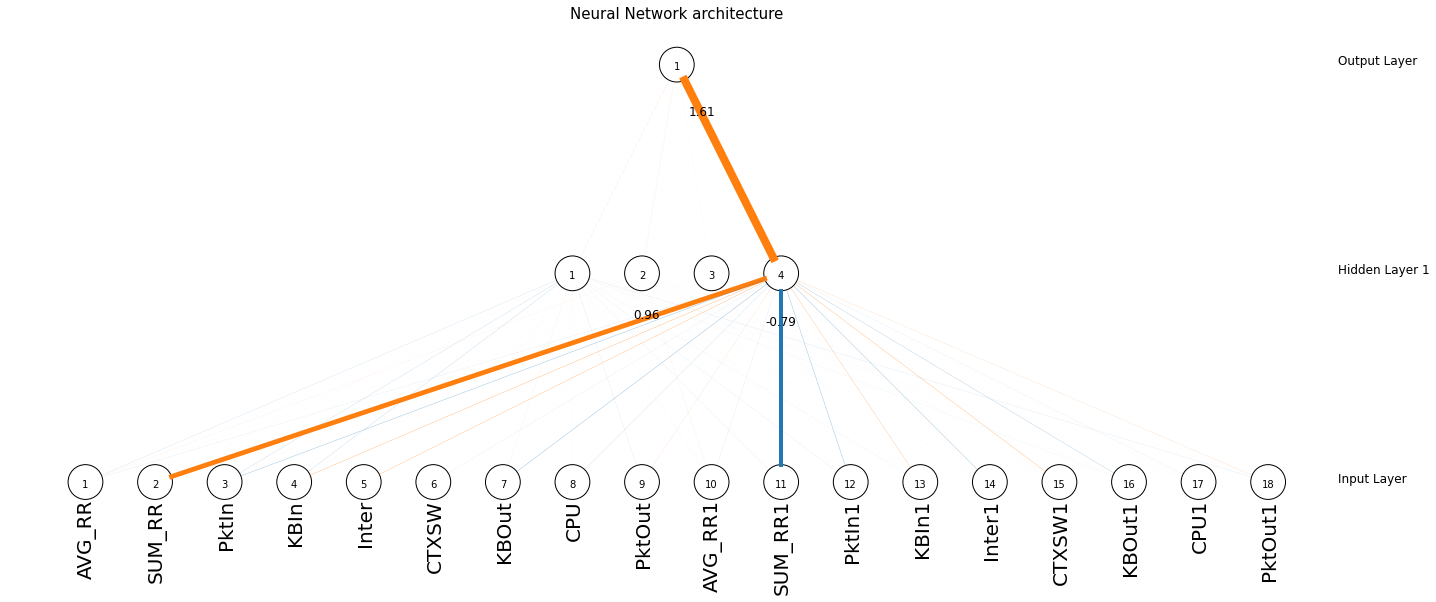

In [84]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

In [87]:
# kumulatív hiba számolásával

In [88]:

columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut', 'AVG_RR1', 'SUM_RR1', 'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'PktOut1']

X = ba[columns].values
y = ba['AVG_LAT_05']


errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop = len(y)-1
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[0:i,:]
  y_train = y_scaled[0:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]


  activation_function = 'relu'        # tanh, relu, logistic

  mlp = MLPRegressor(hidden_layer_sizes=4,
                            max_iter=500,
                            activation=activation_function,
                            solver="lbfgs",
                            learning_rate="constant",
                            learning_rate_init=0.01,
                            alpha=0.01,
                            verbose=False,
                            momentum=0.9,
                            early_stopping=False,
                            tol=0.00000001,
                            shuffle=False,
                            # n_iter_no_change=20, \
                            random_state=1234)


  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  # print('r2 train = ', r2_train)

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])


step =  100 	 r2 =  1.0
step =  150 	 r2 =  0.9041675333260989
step =  200 	 r2 =  0.8899558323004514
step =  250 	 r2 =  0.9118401677685763
step =  300 	 r2 =  0.9037248160074667
step =  350 	 r2 =  0.8777538607384336
step =  400 	 r2 =  0.8693154807356409


[29.9949005]


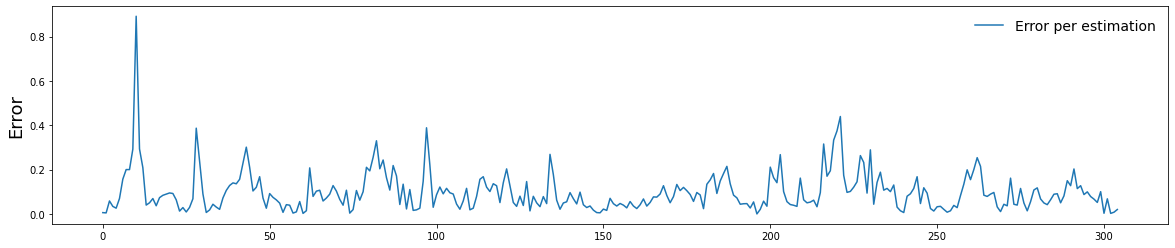

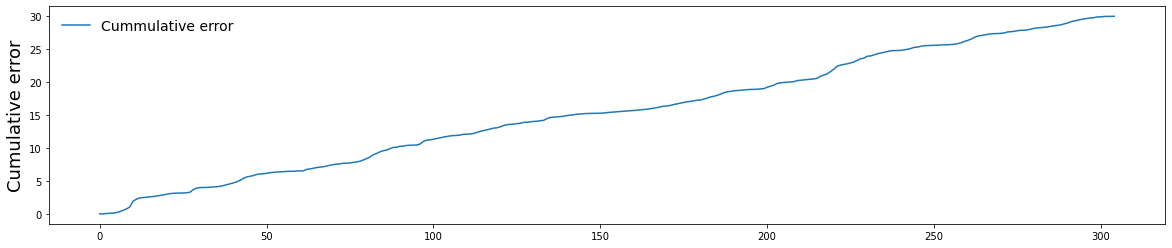

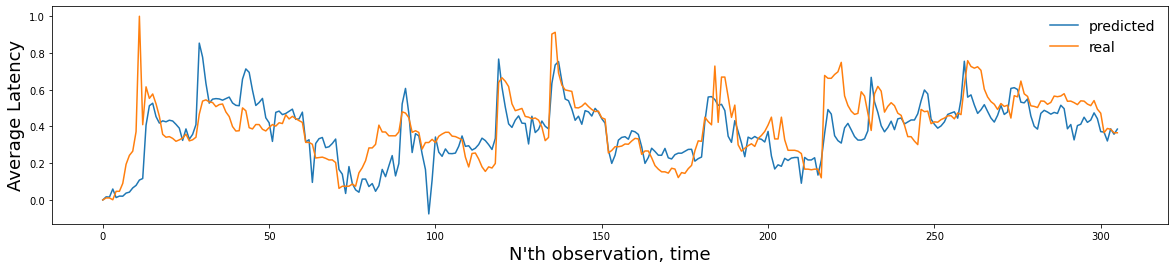

In [89]:
print(cummulative_error)

cummulative_plots(errors, cummulative_errors, y_real[100:880], y_predicted[100:880])

In [90]:
r2 = np.corrcoef(y_real, y_predicted)[0,1]

r2

0.8670998767069161

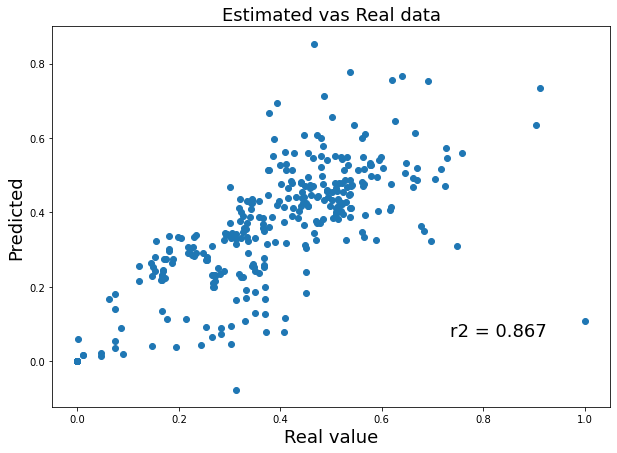

In [91]:
cummaulative_real_predicted_scatter(y_real, y_predicted)

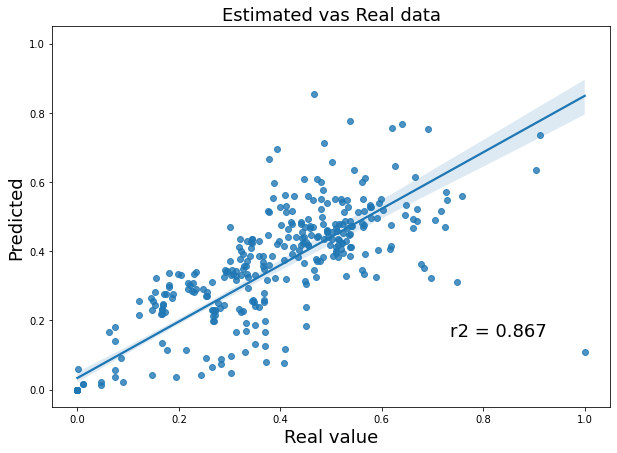

In [92]:
cummaulative_real_predicted_scatter_sns(y_real, y_predicted)

In [93]:

columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut', 'AVG_RR1', 'SUM_RR1', 'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'PktOut1']

X = ba[columns].values
y = ba['AVG_LAT_05']


errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop = len(y)-1
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[0:i,:]
  y_train = y_scaled[0:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]


  activation_function = 'relu'        # tanh, relu, logistic

  mlp = MLPRegressor(hidden_layer_sizes=4,
                            max_iter=500,
                            activation=activation_function,
                            solver="lbfgs",
                            learning_rate="constant",
                            learning_rate_init=0.01,
                            alpha=0.01,
                            verbose=False,
                            momentum=0.9,
                            early_stopping=False,
                            tol=0.00000001,
                            shuffle=False,
                            # n_iter_no_change=20, \
                            random_state=1234)


  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  # print('r2 train = ', r2_train)

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])


step =  100 	 r2 =  1.0
step =  150 	 r2 =  0.9041675333260989
step =  200 	 r2 =  0.8899558323004514
step =  250 	 r2 =  0.9118401677685763
step =  300 	 r2 =  0.9037248160074667
step =  350 	 r2 =  0.8777538607384336
step =  400 	 r2 =  0.8693154807356409


[29.9949005]


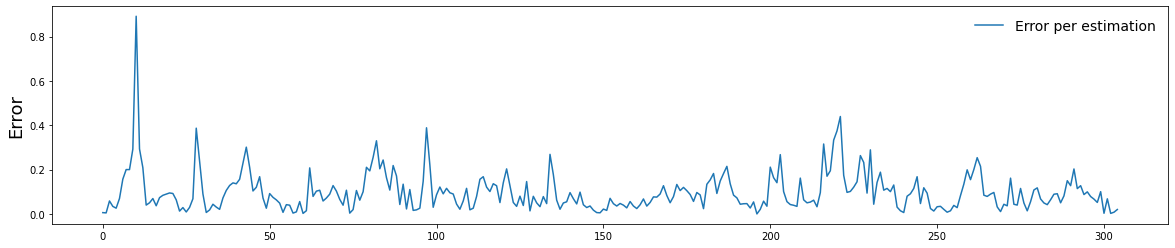

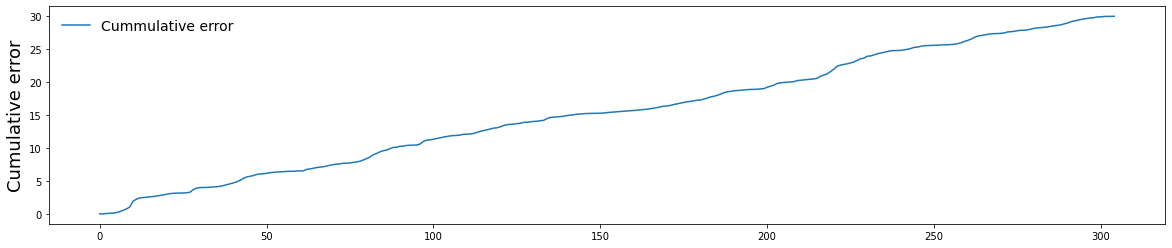

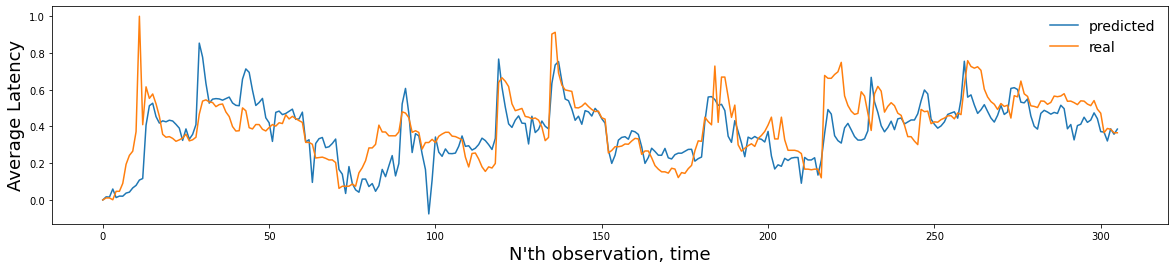

In [94]:
print(cummulative_error)

cummulative_plots(errors, cummulative_errors, y_real[100:880], y_predicted[100:880])

In [95]:
r2 = np.corrcoef(y_real, y_predicted)[0,1]

r2

0.8670998767069161

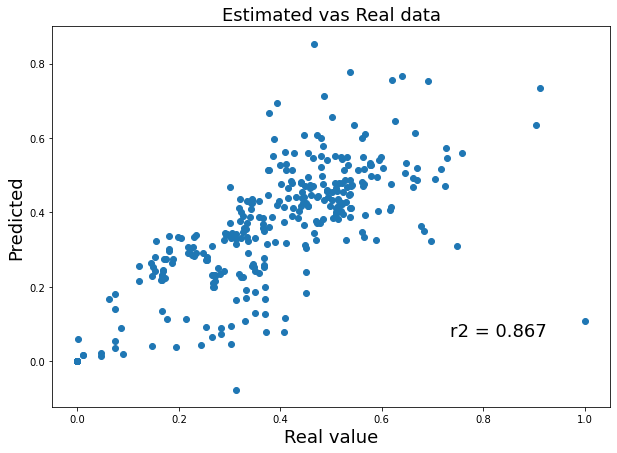

In [96]:
cummaulative_real_predicted_scatter(y_real, y_predicted)

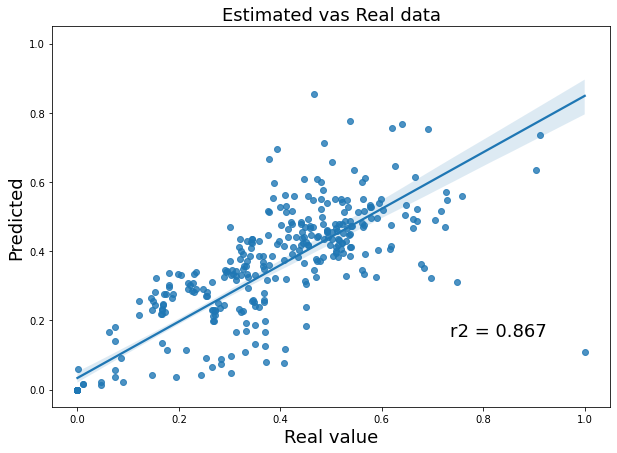

In [97]:
cummaulative_real_predicted_scatter_sns(y_real, y_predicted)

In [98]:
# lagok nélküli futó hiba

In [99]:
X = ba[['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']].values
y = ba['AVG_LAT_05']


errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop = len(y)-1
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[0:i,:]
  y_train = y_scaled[0:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]

  activation_function = 'relu'        # tanh, relu, logistic

  mlp = MLPRegressor(hidden_layer_sizes=4,
                            max_iter=500,
                            activation=activation_function,
                            solver="lbfgs",
                            learning_rate="constant",
                            learning_rate_init=0.01,
                            alpha=0.01,
                            verbose=False,
                            momentum=0.9,
                            early_stopping=False,
                            tol=0.00000001,
                            shuffle=False,
                            # n_iter_no_change=20, \
                            random_state=1234)


  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  # print('r2 train = ', r2_train)

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])


step =  100 	 r2 =  1.0
step =  150 	 r2 =  0.9048521783207849
step =  200 	 r2 =  0.8795812469408681
step =  250 	 r2 =  0.8987421744904915
step =  300 	 r2 =  0.8876996195311588
step =  350 	 r2 =  0.8560715091644007
step =  400 	 r2 =  0.8506940387857679


[30.28859043]


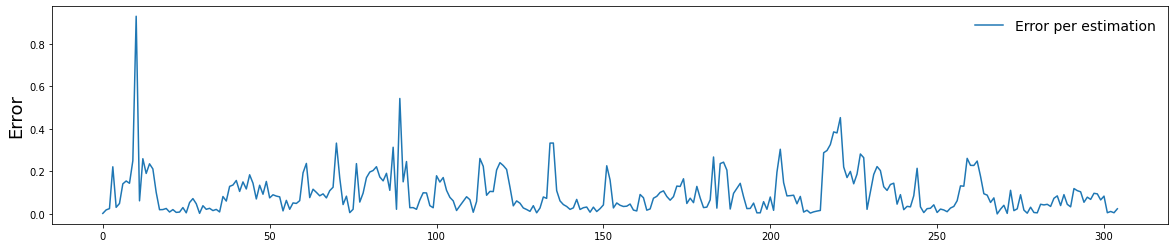

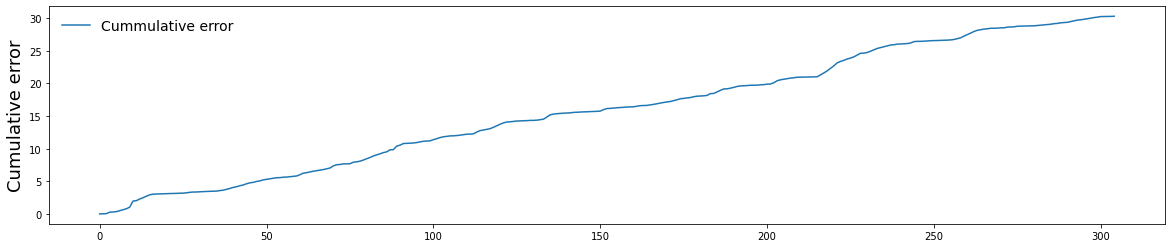

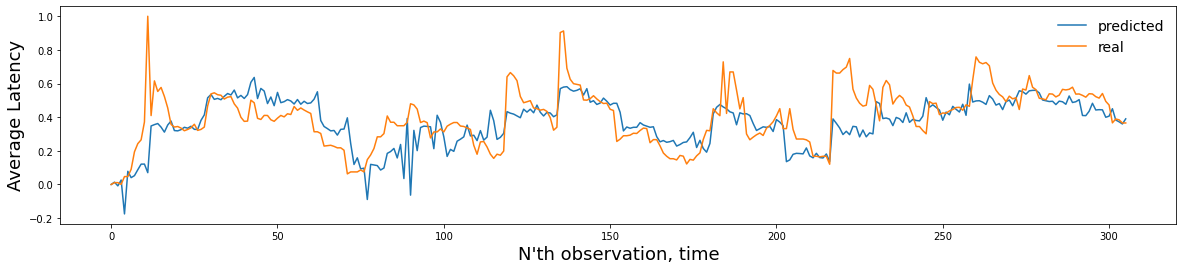

In [100]:
print(cummulative_error)

cummulative_plots(errors, cummulative_errors, y_real[100:880], y_predicted[100:880])

In [101]:
r2 = np.corrcoef(y_real, y_predicted)[0,1]

r2

0.8481080573164094

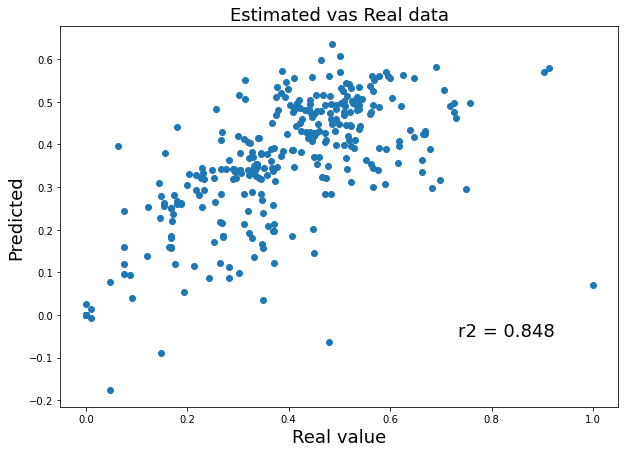

In [102]:
cummaulative_real_predicted_scatter(y_real, y_predicted)

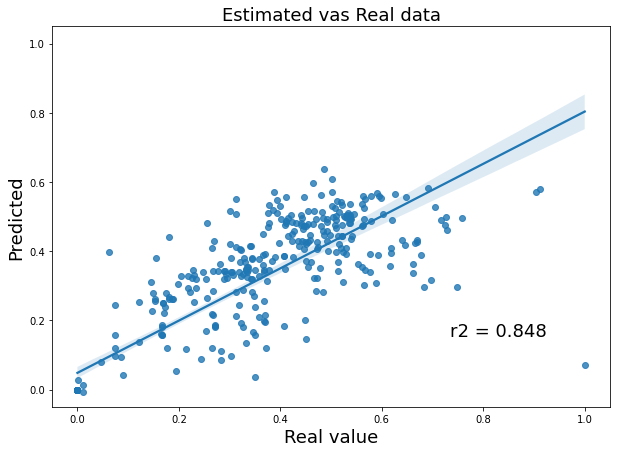

In [103]:
cummaulative_real_predicted_scatter_sns(y_real, y_predicted)

In [104]:
# lagok nélküli futó hiba összetetteb hálóval

In [105]:
X = ba[['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']].values
y = ba['AVG_LAT_05']


errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop = len(y)-1
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[0:i,:]
  y_train = y_scaled[0:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]

  activation_function = 'relu'        # tanh, relu, logistic

  mlp = MLPRegressor(hidden_layer_sizes=10,
                            max_iter=500,
                            activation=activation_function,
                            solver="lbfgs",
                            learning_rate="constant",
                            learning_rate_init=0.01,
                            alpha=0.01,
                            verbose=False,
                            momentum=0.9,
                            early_stopping=False,
                            tol=0.00000001,
                            shuffle=False,
                            # n_iter_no_change=20, \
                            random_state=1234)


  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])


step =  100 	 r2 =  1.0
step =  150 	 r2 =  0.8881609077597915
step =  200 	 r2 =  0.8363770382010134
step =  250 	 r2 =  0.8635651806698671
step =  300 	 r2 =  0.8537319682444819
step =  350 	 r2 =  0.8237539289932801
step =  400 	 r2 =  0.8141244884700531


[33.73870233]


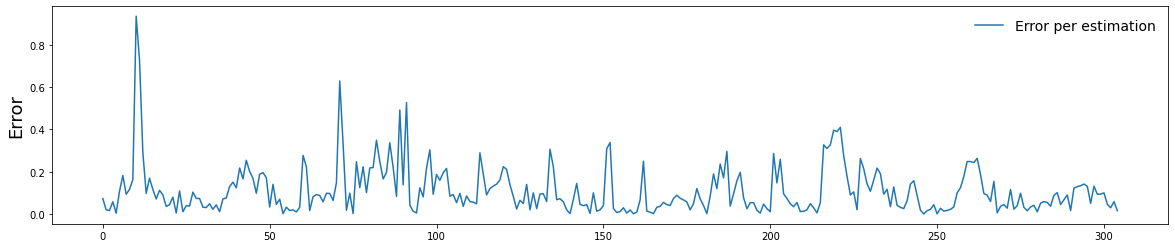

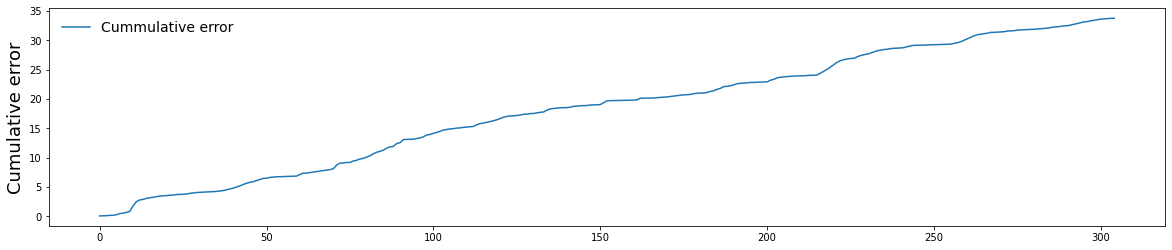

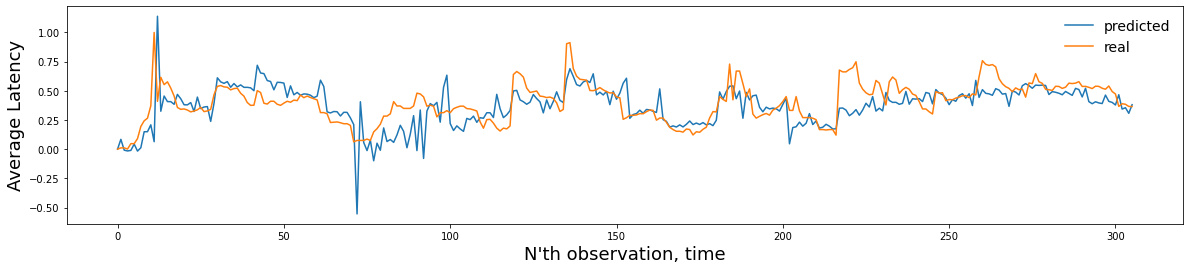

In [106]:
print(cummulative_error)

cummulative_plots(errors, cummulative_errors, y_real[100:880], y_predicted[100:880])

In [107]:
r2 = np.corrcoef(y_real, y_predicted)[0,1]

r2

0.8111502880973274

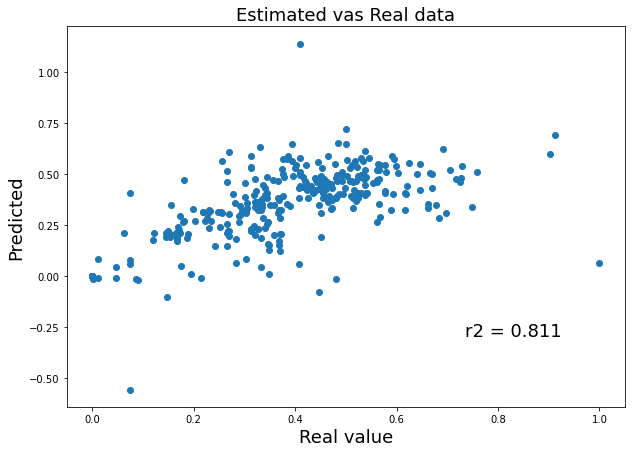

In [108]:
cummaulative_real_predicted_scatter(y_real, y_predicted)

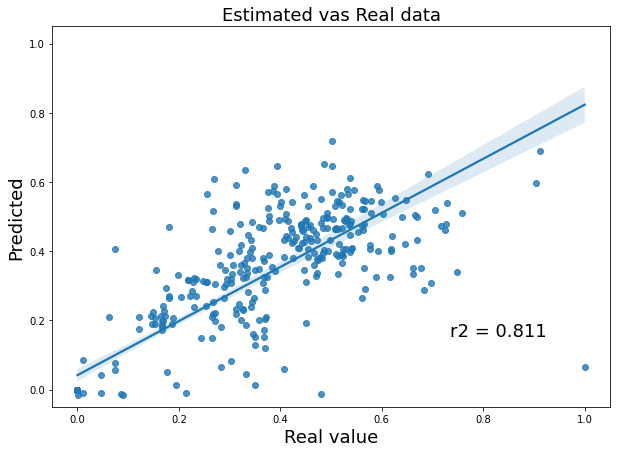

In [109]:
cummaulative_real_predicted_scatter_sns(y_real, y_predicted)

# Playground

Itt ki lehet próbálni mindeféle beállítást, és ha találok valami érdkeset akkor azt tovább lehet gondolni


In [110]:
playground_cumulative_errors = []

In [111]:
def playground_plots(playground_cumulative_errors=None):
  if(len(playground_cumulative_errors) > 0):
    plt.figure(figsize=(20,6))
    for i in playground_cumulative_errors:
      plt.plot(i[2], label = str(i[0]))
      plt.ylabel('Cumulative error', fontsize=18)
      plt.legend(fontsize=14, frameon=False)
    plt.show()


In [112]:
# NN laggal

In [113]:
ba.columns

Index(['timestamp', 'PktIn', 'KBIn', 'AVG_RR', 'Inter', 'CTXSW', 'KBOut',
       'CPU', 'SUM_RR', 'PktOut', 'vm_number', 'AVG_LAT_05', 'timestamp1',
       'PktIn1', 'KBIn1', 'AVG_RR1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1',
       'SUM_RR1', 'PktOut1', 'vm_number1', 'AVG_LAT_051'],
      dtype='object')

In [114]:
columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut',
           'AVG_RR1', 'SUM_RR1', 'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1', 'PktOut1']

# columns = ['PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut', 'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1', 'PktOut1']

# columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']


X = ba[columns].values
y = ba['AVG_LAT_05']

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=1, shuffle=False)

activation_function = 'tanh'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=(10,4),
                           max_iter=1000,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           # n_iter_no_change=20, \
                           random_state=1234)


mlp.fit(X_train, y_train)

y_pred_train = mlp.predict(X_train)
y_pred_test  = mlp.predict(X_test)

r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

r2 train =  0.9458853950642023
r2 test  =  0.5236547775163586


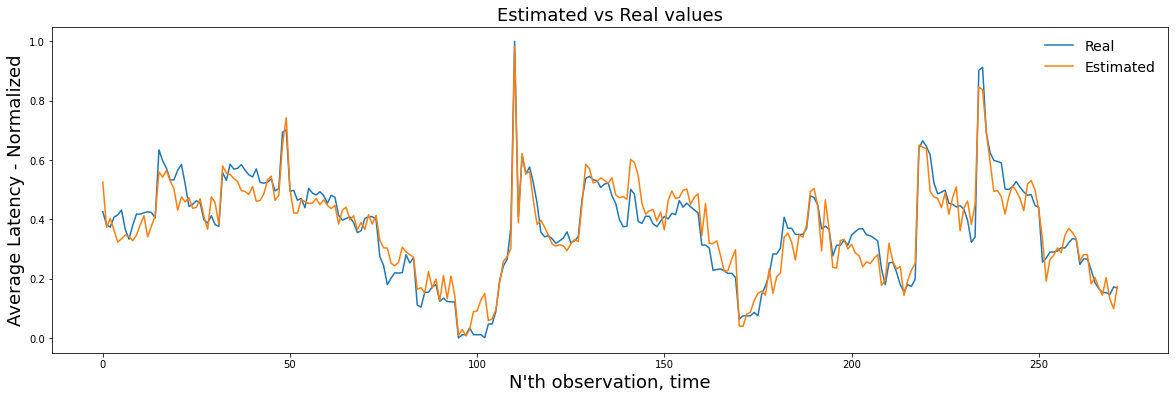

In [115]:
timeline_plot(y_train, y_pred_train)

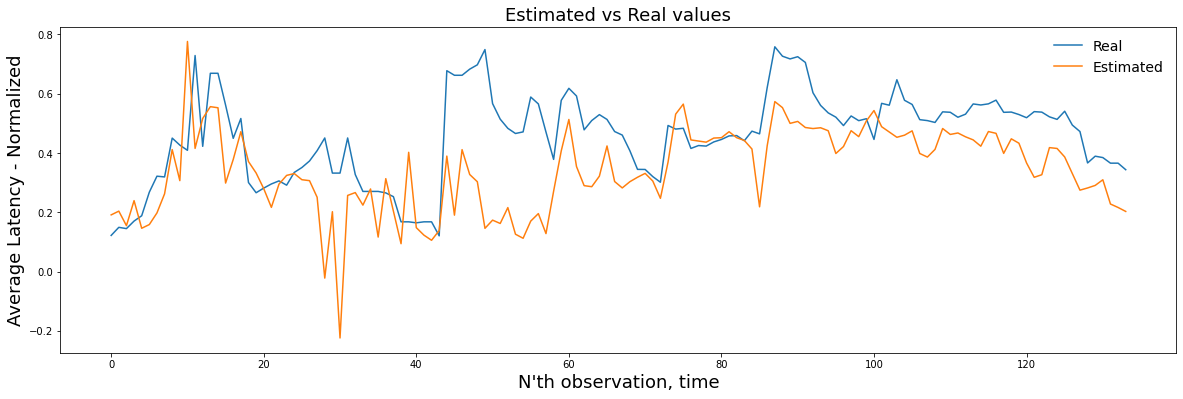

In [116]:
timeline_plot(y_test, y_pred_test)

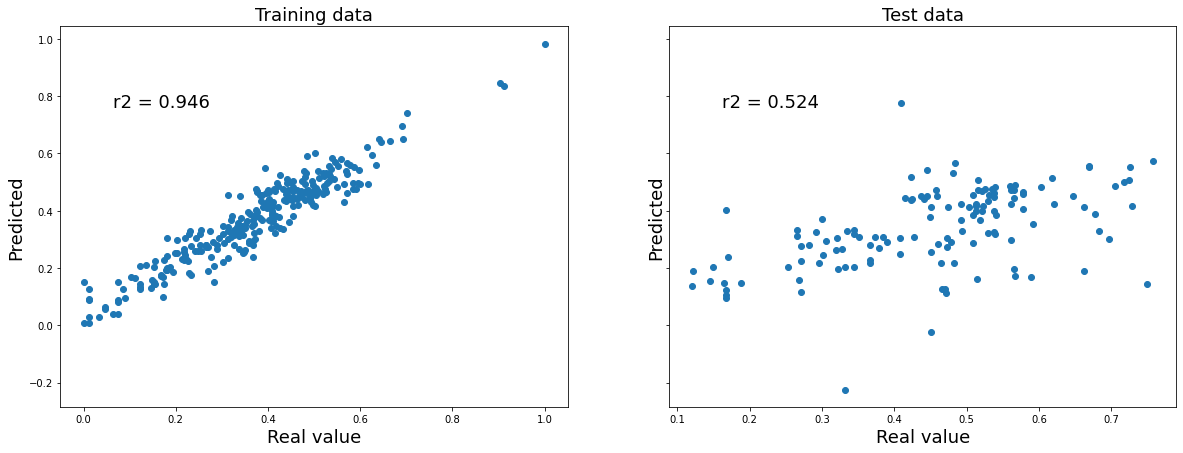

In [117]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

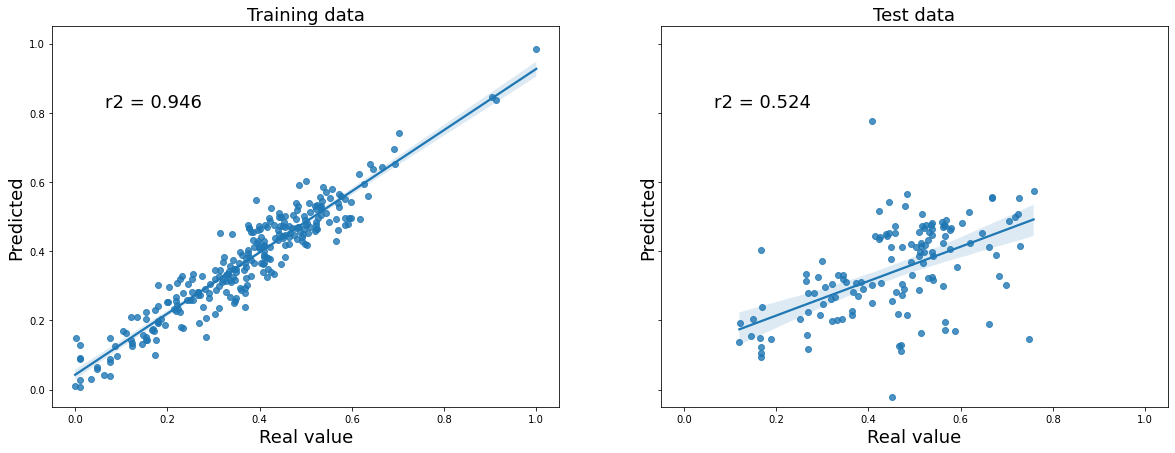

In [118]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)

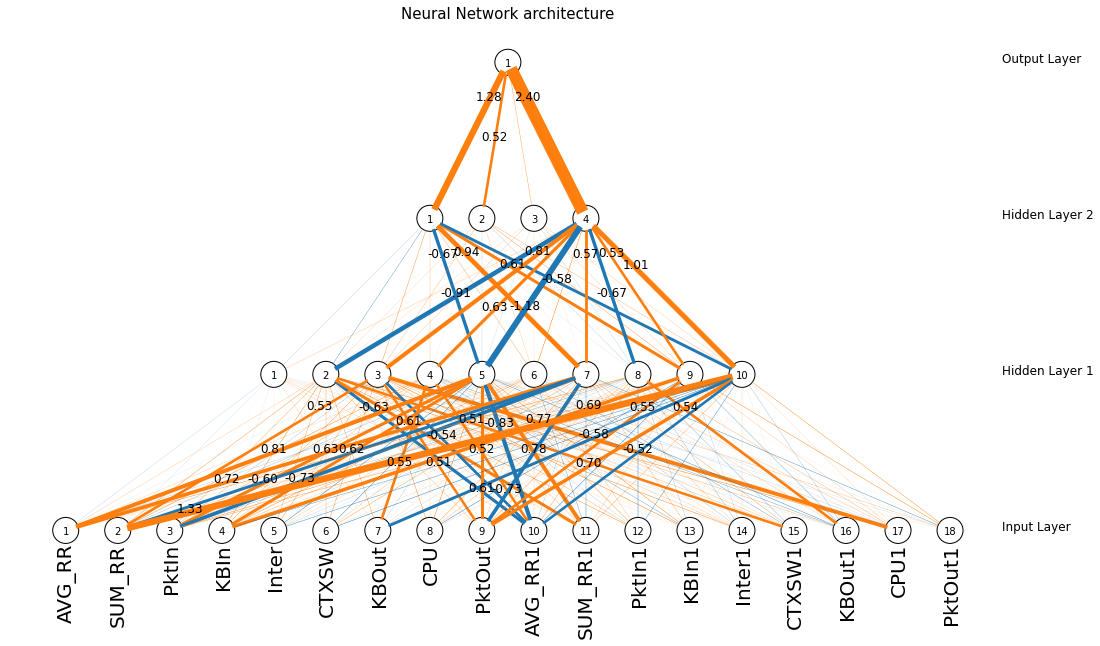

In [119]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

In [120]:
errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop =  len(y)-1
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[0:i,:]
  y_train = y_scaled[0:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]

  mlp = MLPRegressor(hidden_layer_sizes=(10,4),
                     max_iter=i,
                     activation=activation_function,
                     solver="lbfgs",
                     learning_rate="constant",
                     learning_rate_init=0.01,
                     alpha=0.01,
                     verbose=False,
                     momentum=0.9,
                     early_stopping=False,
                     tol=0.00000001,
                     shuffle=False,
                     # n_iter_no_change=20, \
                     random_state=1234)
  
  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])

if( playground_cumulative_errors is not None ):
  name = 'elso'
  playground_cumulative_errors.append((name, mlp, cummulative_errors))


step =  100 	 r2 =  1.0
step =  150 	 r2 =  0.9082273369553053
step =  200 	 r2 =  0.8811580645078659
step =  250 	 r2 =  0.8917045093373713
step =  300 	 r2 =  0.8820351543218241
step =  350 	 r2 =  0.8473197185588789
step =  400 	 r2 =  0.8405397130385728


[31.71988592]


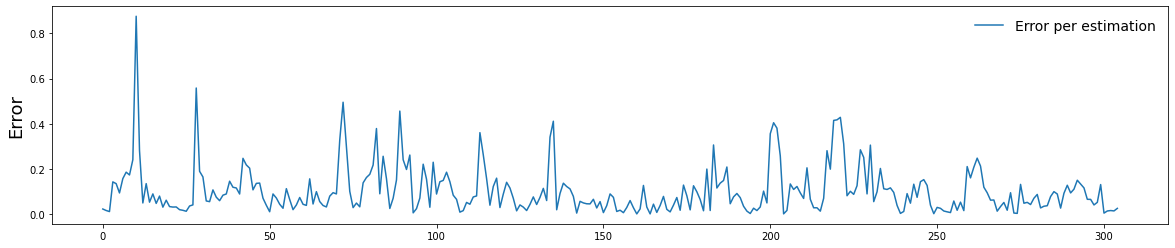

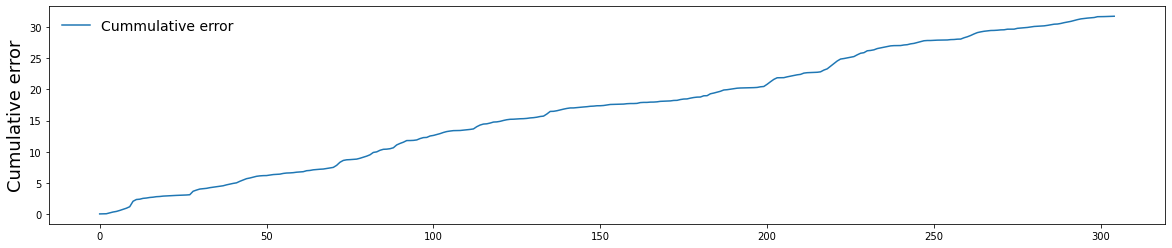

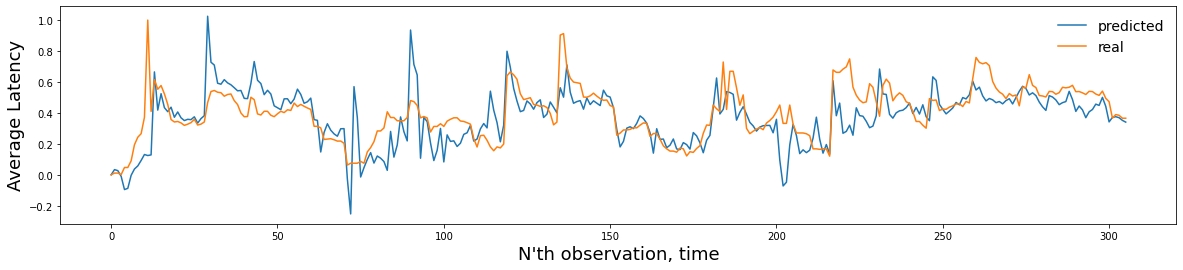

In [121]:
print(cummulative_error)

cummulative_plots(errors, cummulative_errors, y_real[100:880], y_predicted[100:880])

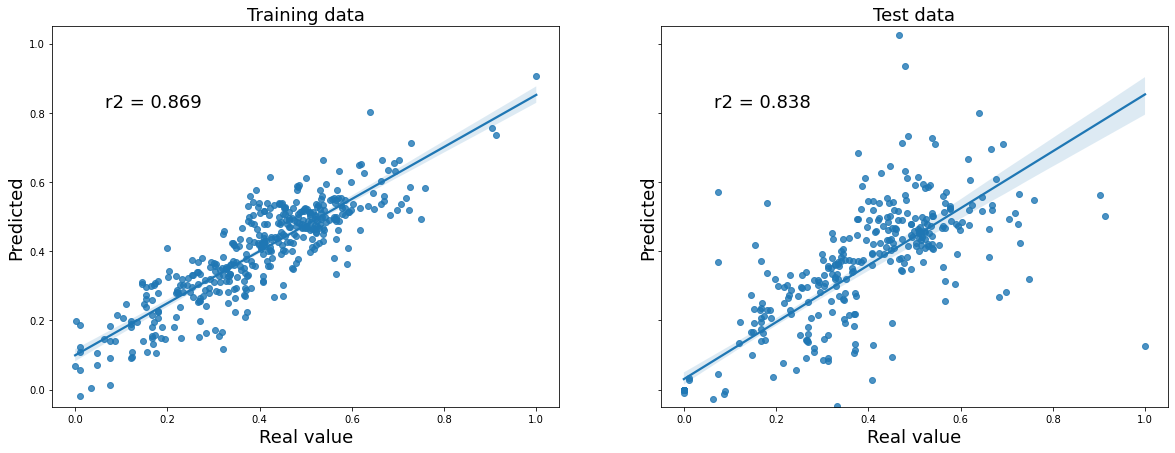

In [122]:
train_test_real_predicted_scatter_sns(y_train, y_real, y_pred_train, y_predicted)

In [123]:
errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop =  len(y)-1
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[0:i,:]
  y_train = y_scaled[0:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]

  mlp = MLPRegressor(hidden_layer_sizes=(10,4),
                     max_iter=500,
                     activation=activation_function,
                     solver="lbfgs",
                     learning_rate="constant",
                     learning_rate_init=0.01,
                     alpha=0.01,
                     verbose=False,
                     momentum=0.9,
                     early_stopping=False,
                     tol=0.00000001,
                     shuffle=False,
                     # n_iter_no_change=20, \
                     random_state=1234)
  
  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])

if( playground_cumulative_errors is not None ):
  name = 'masoidk'
  playground_cumulative_errors.append((name, mlp, cummulative_errors))


step =  100 	 r2 =  -1.0
step =  150 	 r2 =  0.9107188667275079
step =  200 	 r2 =  0.8372210088632973
step =  250 	 r2 =  0.8515492937477377
step =  300 	 r2 =  0.843055566143412
step =  350 	 r2 =  0.8077749454848494
step =  400 	 r2 =  0.7996187330574426


[33.54278507]


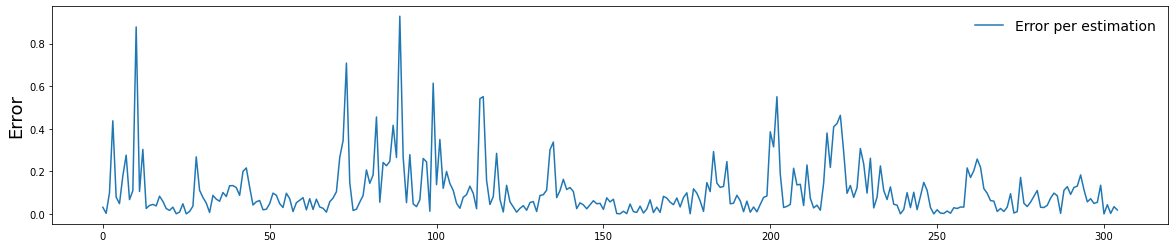

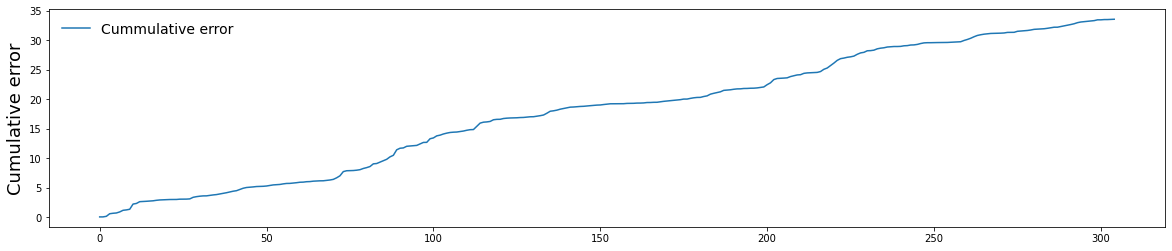

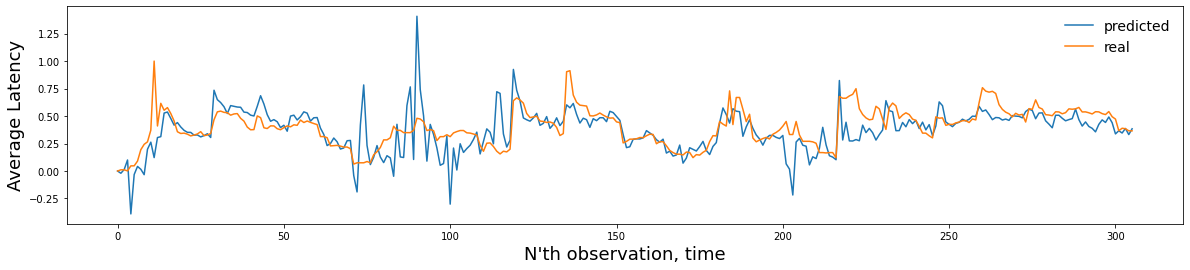

In [124]:
print(cummulative_error)

cummulative_plots(errors, cummulative_errors, y_real[100:880], y_predicted[100:880])

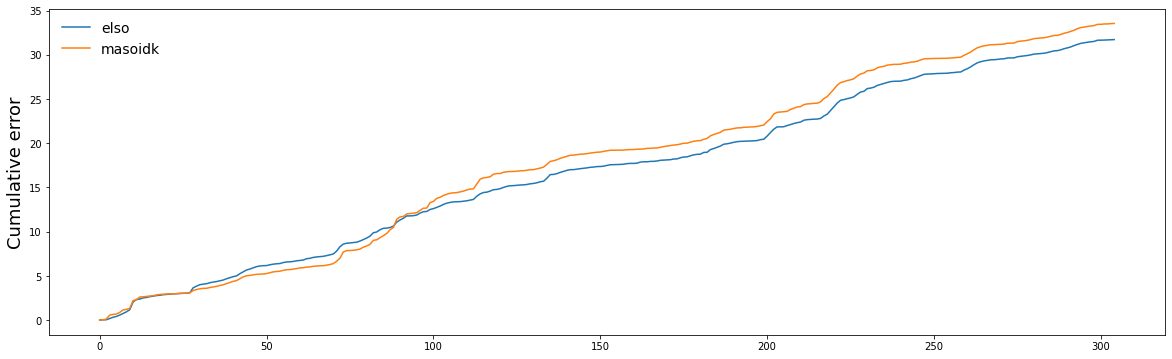

In [125]:
playground_plots(playground_cumulative_errors)

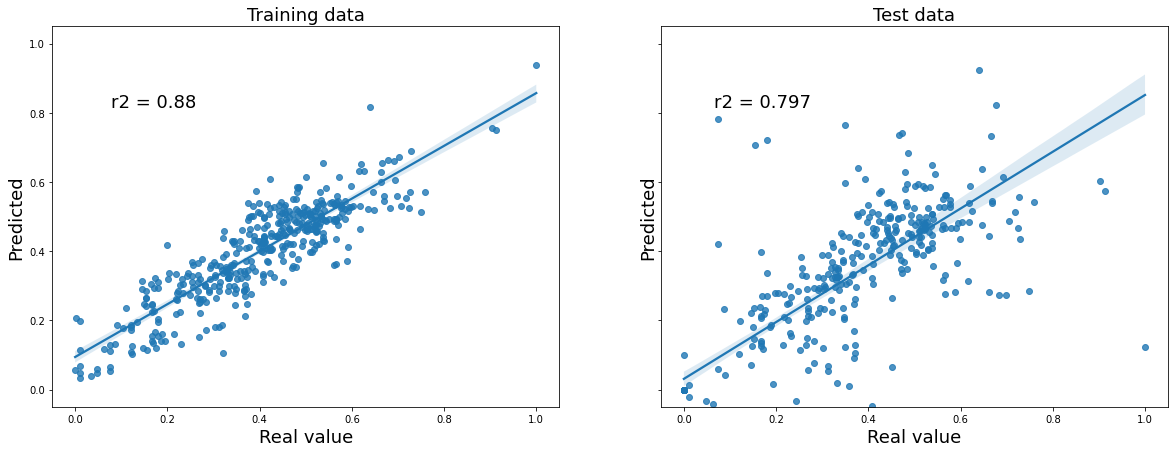

In [126]:
train_test_real_predicted_scatter_sns(y_train, y_real, y_pred_train, y_predicted)

In [127]:
errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop =  len(y)-1
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[0:i,:]
  y_train = y_scaled[0:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]

  mlp = MLPRegressor(hidden_layer_sizes=(10,4),
                     max_iter=int(i/3),
                     activation=activation_function,
                     solver="lbfgs",
                     learning_rate="constant",
                     learning_rate_init=0.01,
                     alpha=0.01,
                     verbose=False,
                     momentum=0.9,
                     early_stopping=False,
                     tol=0.00000001,
                     shuffle=False,
                     # n_iter_no_change=20, \
                     random_state=1234)
  
  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])

if( playground_cumulative_errors is not None ):
  name = 'harmadik'
  playground_cumulative_errors.append((name, mlp, cummulative_errors))


step =  100 	 r2 =  1.0
step =  150 	 r2 =  0.875571474732233
step =  200 	 r2 =  0.8679372772776998
step =  250 	 r2 =  0.8948649667359291
step =  300 	 r2 =  0.8886391237771593
step =  350 	 r2 =  0.8585833158744904
step =  400 	 r2 =  0.8535157523006698


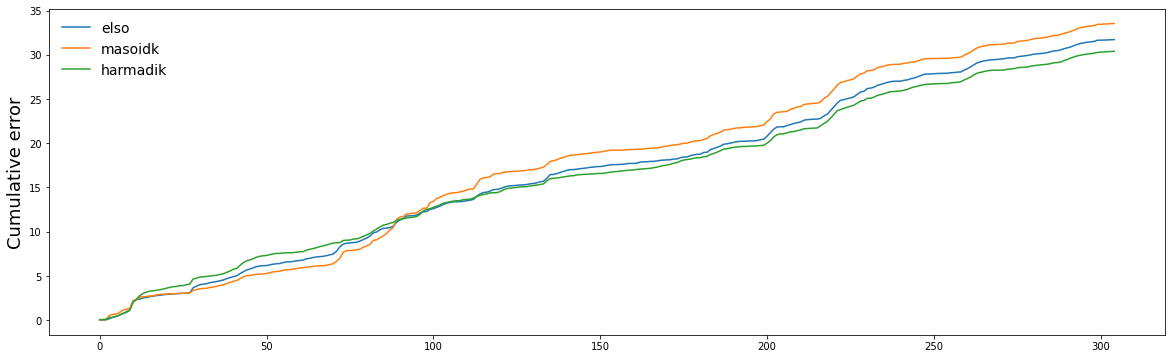

In [128]:
playground_plots(playground_cumulative_errors)

In [129]:
errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop =  len(y)-1
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[0:i,:]
  y_train = y_scaled[0:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]

  mlp = MLPRegressor(hidden_layer_sizes=(20,10),
                     max_iter=int(i/3),
                     activation=activation_function,
                     solver="lbfgs",
                     learning_rate="constant",
                     learning_rate_init=0.1,
                     alpha=0.01,
                     verbose=False,
                     momentum=0.9,
                     early_stopping=False,
                     tol=0.00000001,
                     shuffle=False,
                     # n_iter_no_change=20, \
                     random_state=1234)
  
  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])

if( playground_cumulative_errors is not None ):
  name = 'negyedik'
  playground_cumulative_errors.append((name, mlp, cummulative_errors))


step =  100 	 r2 =  -0.9999999999999901
step =  150 	 r2 =  0.9099000470572457
step =  200 	 r2 =  0.8993058978701706
step =  250 	 r2 =  0.9197524327010987
step =  300 	 r2 =  0.9126820969530538
step =  350 	 r2 =  0.8733560763178666
step =  400 	 r2 =  0.8685274407912124


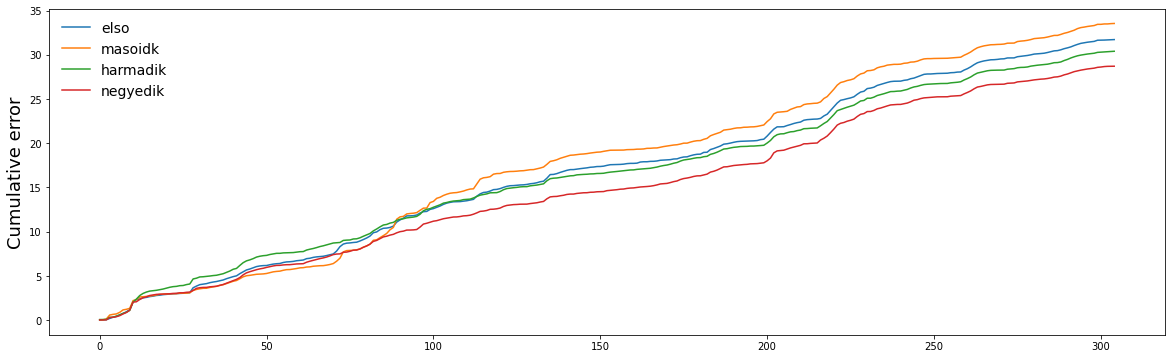

In [130]:
playground_plots(playground_cumulative_errors)

In [131]:

columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut',
           'AVG_RR1', 'SUM_RR1', 'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1', 'PktOut1']

# columns = ['PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut', 'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1', 'PktOut1']

# columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']


X = ba[columns].values
y = ba['AVG_LAT_05']

errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop =  len(y)-1
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[i-10:i,:]
  y_train = y_scaled[i-10:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]

  mlp = MLPRegressor(hidden_layer_sizes=(20,10),
                     max_iter=int(i*3),
                     activation=activation_function,
                     solver="lbfgs",
                     learning_rate="constant",
                     learning_rate_init=0.099,
                     alpha=0.01,
                     verbose=False,
                     momentum=0.09,
                     early_stopping=False,
                     tol=0.00000001,
                     shuffle=False,
                     # n_iter_no_change=20, \
                     random_state=1234)
  
  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])

if( playground_cumulative_errors is not None ):
  name = 'ötödik'
  playground_cumulative_errors.append((name, mlp, cummulative_errors))


step =  100 	 r2 =  1.0
step =  150 	 r2 =  0.9127428634918163
step =  200 	 r2 =  0.9162471138684741
step =  250 	 r2 =  0.9209960298569078
step =  300 	 r2 =  0.8703448335341558
step =  350 	 r2 =  0.8585868327650383
step =  400 	 r2 =  0.8531477991990808


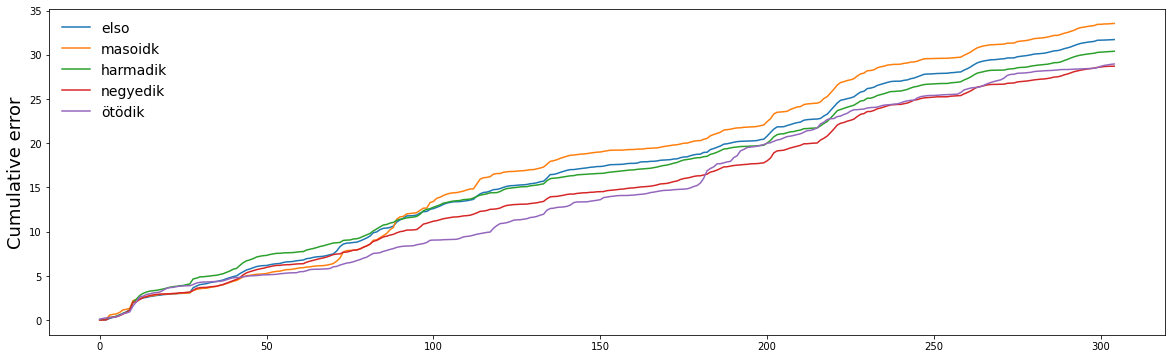

In [132]:
playground_plots(playground_cumulative_errors)

[28.96315652]


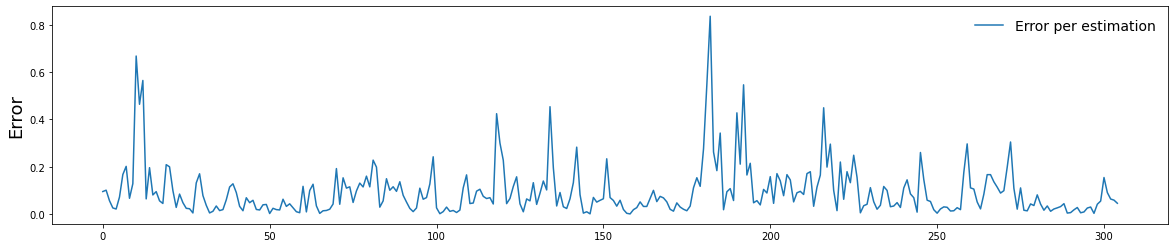

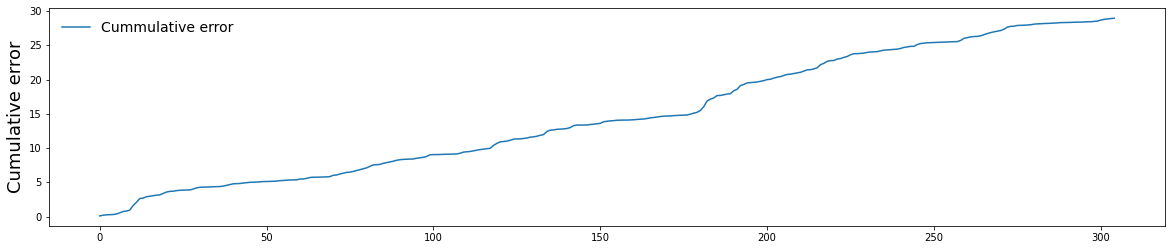

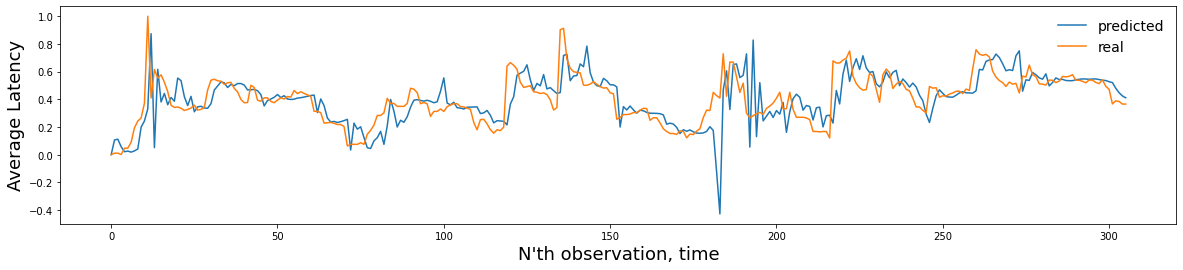

In [133]:
print(cummulative_error)

cummulative_plots(errors, cummulative_errors, y_real[100:880], y_predicted[100:880])

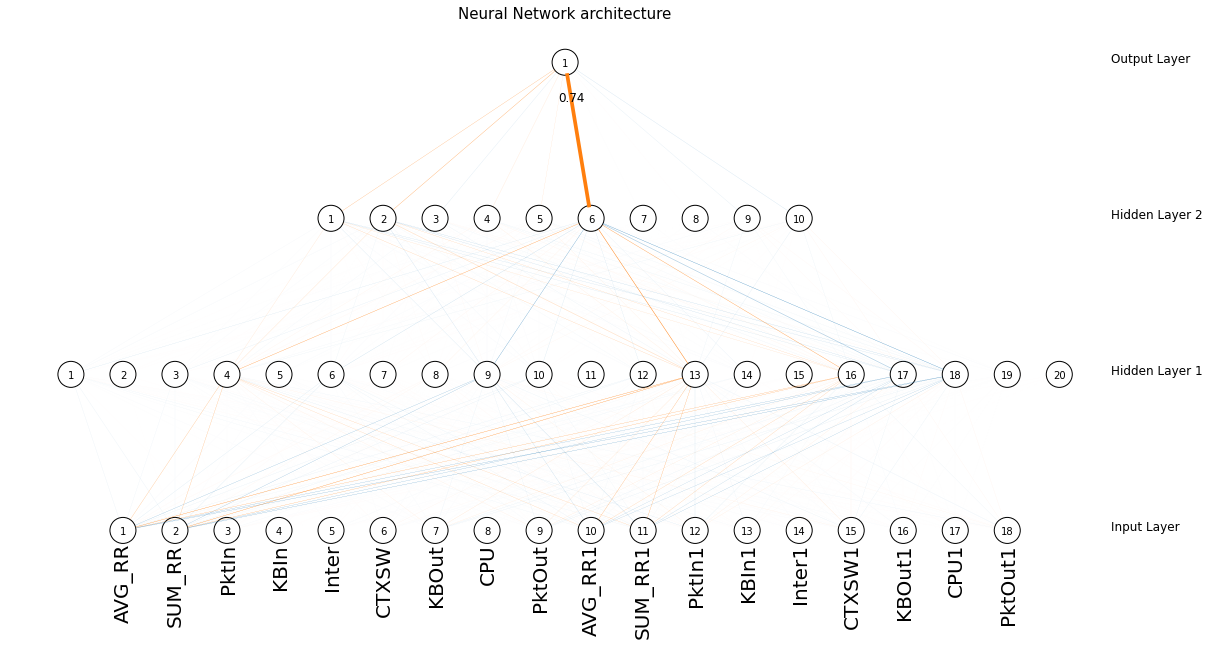

In [134]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

In [135]:

columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut',
           'AVG_RR1', 'SUM_RR1', 'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1', 'PktOut1']

columns = ['PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut', 'PktIn1', 'KBIn1', 'Inter1', 'CTXSW1', 'KBOut1', 'CPU1', 'PktOut1']

# columns = ['AVG_RR', 'SUM_RR', 'PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']


X = ba[columns].values
y = ba['AVG_LAT_05']

errors = []
cummulative_errors = []
y_predicted = np.zeros(len(X))
y_real = np.zeros(len(X))
cummulative_error = 0
start = 100
stop =  len(y)-1
for i in range(start, stop):

  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

  X_train = X_scaled[i-100:i,:]
  y_train = y_scaled[i-100:i,:]
  X_test  = X_scaled[i:i+1,:]
  y_test  = y_scaled[i:i+1,:]

  mlp = MLPRegressor(hidden_layer_sizes=(20,10),
                     max_iter=int(i*3),
                     activation=activation_function,
                     solver="lbfgs",
                     learning_rate="constant",
                     learning_rate_init=0.099,
                     alpha=0.01,
                     verbose=False,
                     momentum=0.09,
                     early_stopping=False,
                     tol=0.00000001,
                     shuffle=False,
                     # n_iter_no_change=20, \
                     random_state=1234)
  
  mlp.fit(X_train, y_train)

  y_pred_train = mlp.predict(X_train)
  y_pred_test  = mlp.predict(X_test)

  r2_train = np.corrcoef(y_train.ravel(), y_pred_train)[0,1]
  r2_test  = np.corrcoef(y_test.ravel(), y_pred_test)[0,1]

  error = y_test[0]-y_pred_test[0]
  abs_error = abs(error)
  errors.append(abs_error)
  cummulative_error = cummulative_error + abs_error
  # print(cummulative_error)
  cummulative_errors.append(cummulative_error)
  y_predicted[i+1] = y_pred_test[0]
  y_real[i+1] = y_test[0]

  if( i % 50 == 0 ):
    print('step = ', i, '\t', 'r2 = ', np.corrcoef(y_real, y_predicted)[0,1])

if( playground_cumulative_errors is not None ):
  name = 'hatodik'
  playground_cumulative_errors.append((name, mlp, cummulative_errors))


step =  100 	 r2 =  -0.9999999999999921
step =  150 	 r2 =  0.9055215709109512
step =  200 	 r2 =  0.7645556849896056
step =  250 	 r2 =  0.7870927432972723
step =  300 	 r2 =  0.7658959006375845
step =  350 	 r2 =  0.7272607057379046
step =  400 	 r2 =  0.7270606921084937


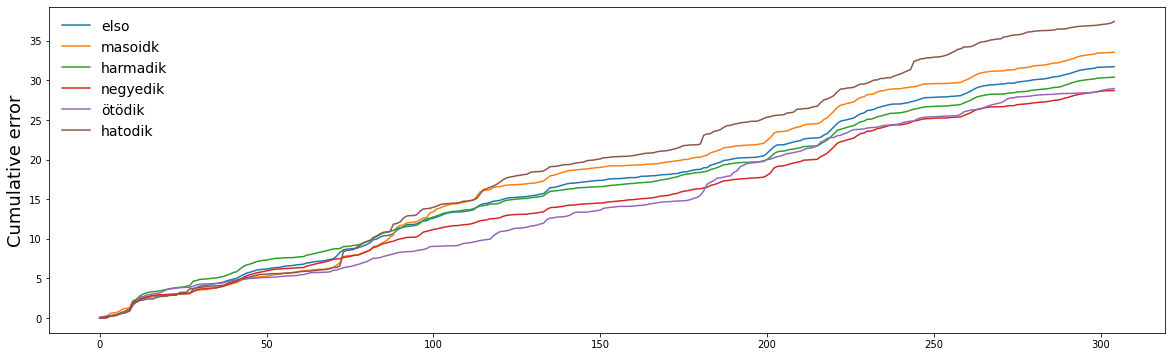

In [136]:
playground_plots(playground_cumulative_errors)

[37.42798877]


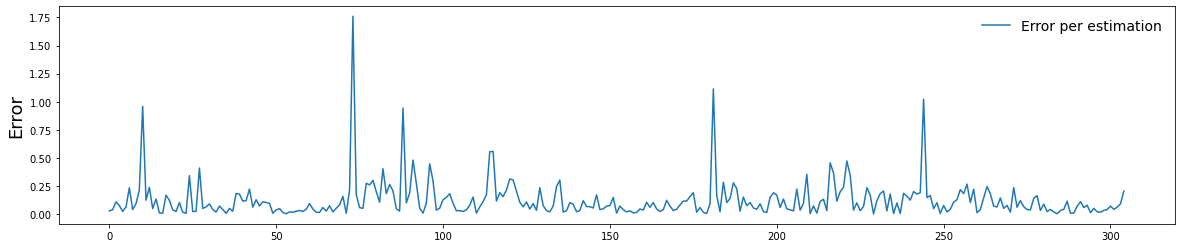

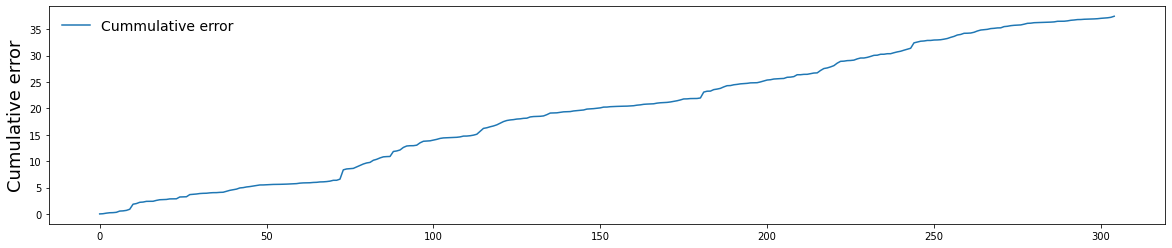

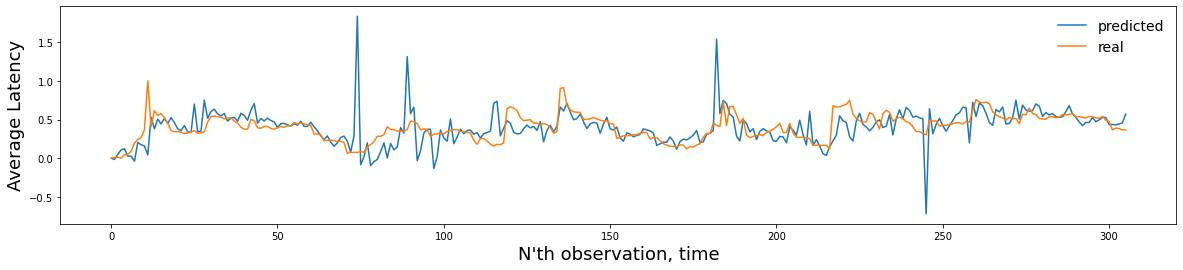

In [137]:
print(cummulative_error)

cummulative_plots(errors, cummulative_errors, y_real[100:880], y_predicted[100:880])

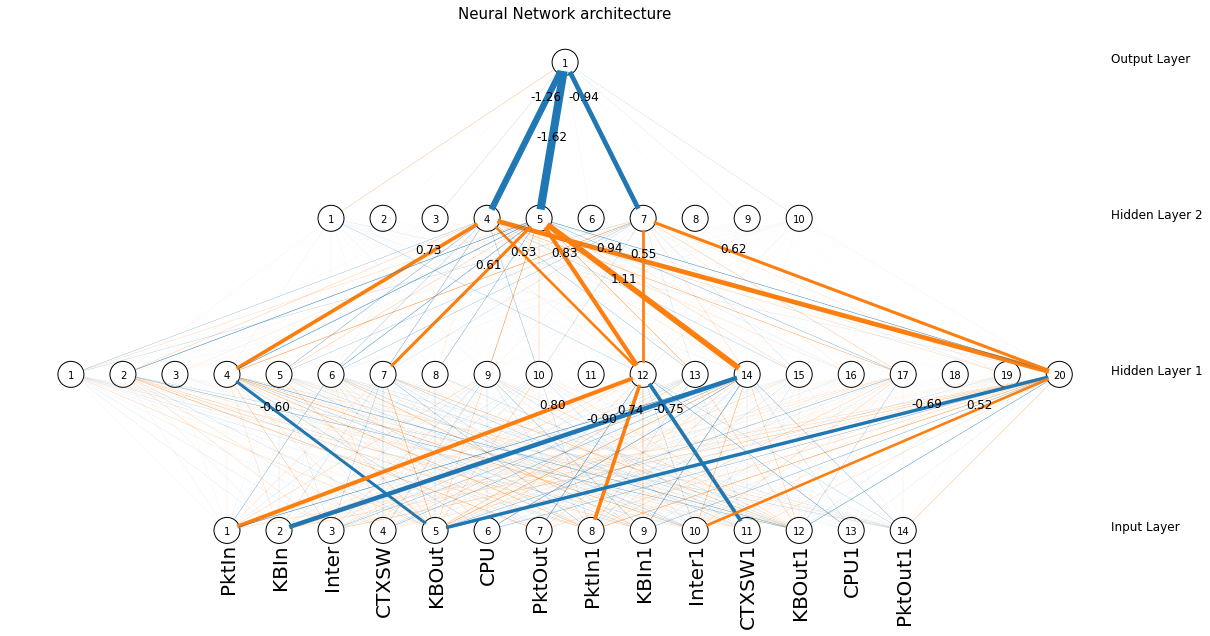

In [138]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

# Playgroud end

# SandBox

In [139]:
columns = ['PktIn', 'KBIn', 'Inter', 'CTXSW', 'KBOut', 'CPU', 'PktOut']

X = df[columns].values
y = df['AVG_LAT_05']

min_max_scaler_X = preprocessing.MinMaxScaler()
min_max_scaler_y = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler_X.fit_transform(X)
y_scaled = min_max_scaler_y.fit_transform(y.values.reshape(-1, 1))

X_ = X_scaled
y_ = y_scaled

activation_function = 'relu'        # tanh, relu, logistic

mlp = MLPRegressor(hidden_layer_sizes=(4,),
                           max_iter=500,
                           activation=activation_function,
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           # n_iter_no_change=20, \
                           random_state=1234)


mlp.fit(X_, y_)

print('')

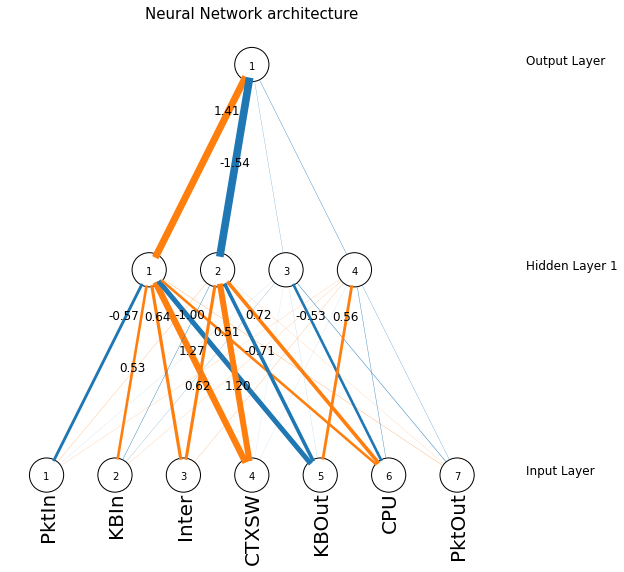

In [140]:
# Define the structure of the network
network_structure = np.hstack(([len(columns)], np.asarray(mlp.hidden_layer_sizes), [1]))

# Draw the Neural Network with weights
network=DrawNN(network_structure, mlp.coefs_, columns)
# network=DrawNN([3,4,1])
network.draw()

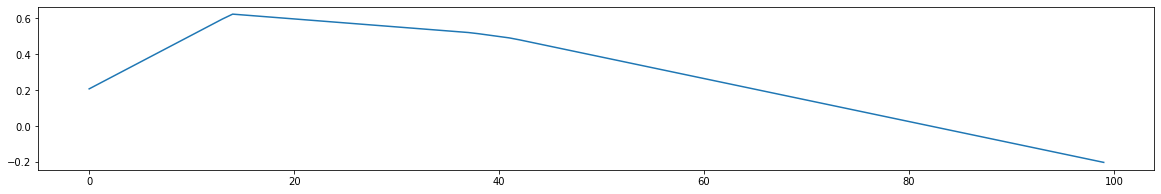

In [141]:
time = 300

tf = df[columns]
input = tf.iloc[time]

x_array = np.arange(0, 100, 1)

predictions = []
for i in x_array:
  input['CPU'] = i
  X = min_max_scaler_X.transform([input])
  pred = mlp.predict(X)
  predictions.append(pred)

plt.figure(figsize=(20, 3))
plt.plot(predictions)
plt.show()

In [175]:
ido = 40
cpu = 100
matrix = np.zeros((ido, cpu))
for i in range(ido):
  input = tf.iloc[i]
  for j in range(cpu):
    input['CPU'] = j
    X = min_max_scaler_X.transform([input])
    pred = mlp.predict(X)
    matrix[i, j] = pred
    

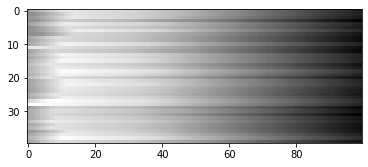

In [171]:
plt.imshow(matrix, cmap='gray'); plt.show()

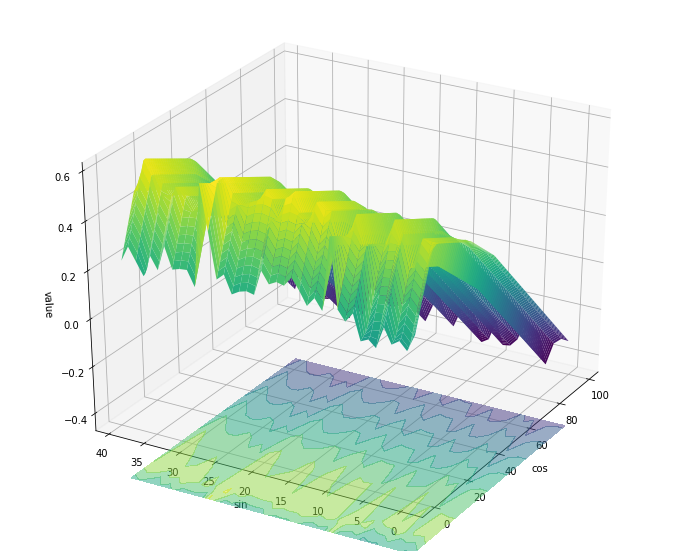

In [176]:
# Ha a mátrixot már korábban kiszámoltuk

step = 5
ido = 100
cpu = 40

ido_space = np.linspace(0, ido-1, ido)
cpu_space = np.linspace(0, cpu-1, cpu)

x, y = np.meshgrid(ido_space, cpu_space)
z = np.zeros_like(x)

for i in range(len(ido_space)):
  i = int(i)
  for j in range(len(cpu_space)-1):
    j = int(j)
    z[j, i] = np.cos(i/10)*np.sin(j/10)

z = matrix

# 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('cos')
ax.set_ylabel('sin')
ax.set_zlabel('value')
surf = ax.plot_surface(x, y, z, rstride = 1, cstride = 1, cmap = 'viridis', linewidth = 0.4, antialiased = True)
cset = ax.contourf(x, y, z, zdir = 'z', offset = -0.7, cmap = 'viridis', alpha = 0.5)
ax.view_init(30, 210)

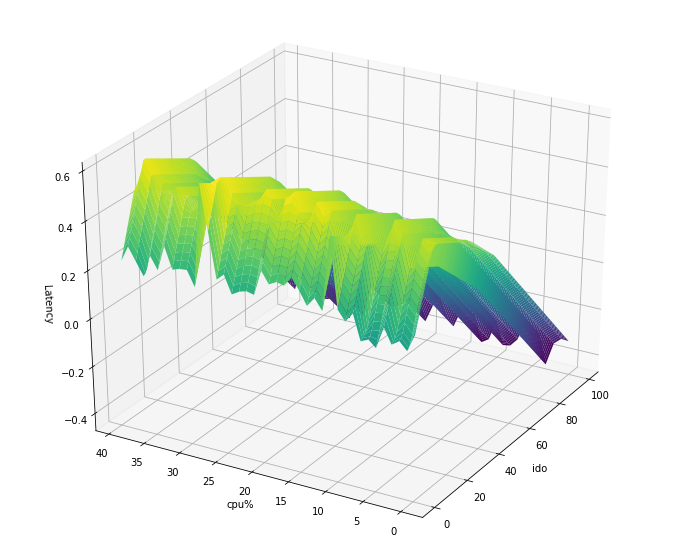

In [177]:
# Ez kiértékelés nagyobb felbontással is elvégezhető te több számítással jár

step = 5
ido = 100
cpu = 40
ido_space = np.linspace(0, ido-1, ido)
cpu_space = np.linspace(0, cpu-1, cpu)

# ido_space = np.arange(start=0, stop = ido, step=1, dtype='float64')
# cpu_space = np.arange(start=0, stop = cpu, step=1, dtype='float64')

x, y = np.meshgrid(ido_space, cpu_space)
z = matrix

# 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('ido')
ax.set_ylabel('cpu%')
ax.set_zlabel('Latency')
surf = ax.plot_surface(x, y, z, rstride = 1, cstride = 1, cmap = 'viridis', linewidth = 0.4, antialiased = True)
cset = ax.contourf(x, y, z, zdir = 'z', offset = -2.5, cmap = 'viridis', alpha = 0.5)
ax.view_init(30, 210)

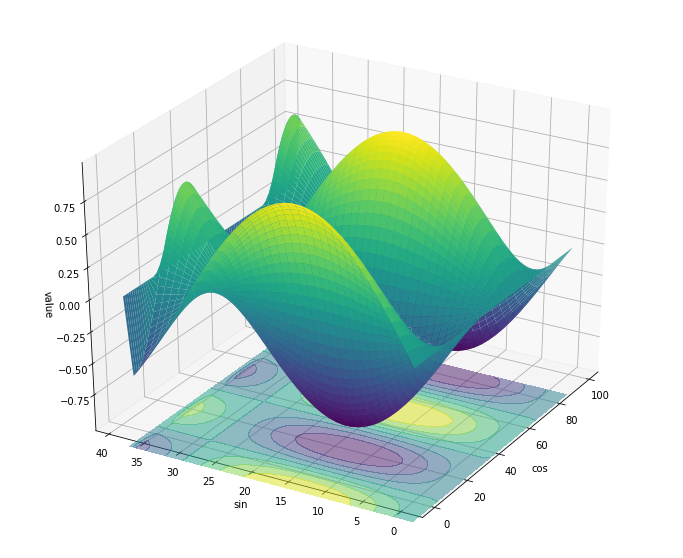

In [168]:
# Fun(i)

step = 5
ido = 100
cpu = 40

ido_space = np.linspace(0, ido-1, ido)
cpu_space = np.linspace(0, cpu-1, cpu)

x, y = np.meshgrid(ido_space, cpu_space)
z = np.zeros_like(x)

for i in range(len(ido_space)):
  i = int(i)
  for j in range(len(cpu_space)-1):
    j = int(j)
    z[j, i] = np.cos(i/10)*np.sin(j/10)

# 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('cos')
ax.set_ylabel('sin')
ax.set_zlabel('value')
surf = ax.plot_surface(x, y, z, rstride = 1, cstride = 1, cmap = 'viridis', linewidth = 0.4, antialiased = True)
cset = ax.contourf(x, y, z, zdir = 'z', offset = -1.2, cmap = 'viridis', alpha = 0.5)
ax.view_init(30, 210)

-----------------------------------
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39.]
-----------------------------------
-----------------------------------
z.shape =  (40, 100)
x.shape =  (40, 100)
y.shape =  (40, 100)
-----------------------------------
-----------------x-----------------
[[ 0.  1.  2. ... 97. 98. 99.]
 [ 0.  1.  2. ... 97. 98. 99.]
 [ 0.  1.  2. ... 97. 98. 99.]
 ...
 [ 0.  1.  2. ... 97. 98. 99.]
 [ 0.  1.  2. ... 97. 98. 99.]
 [ 0.  1.  2. ... 97. 98. 

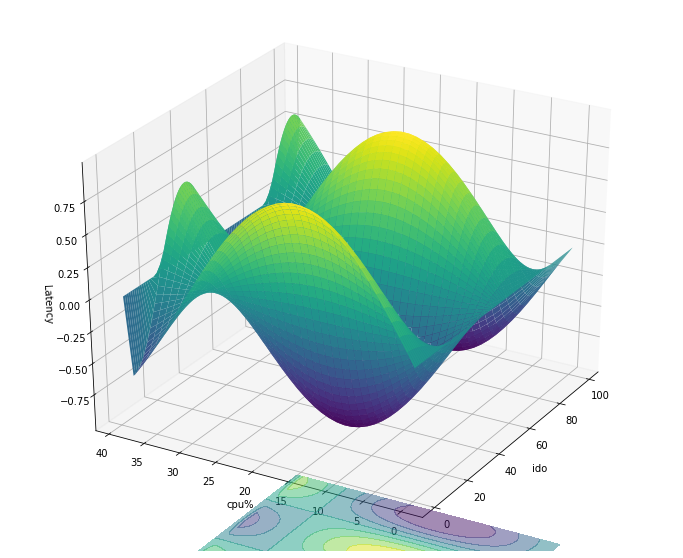

In [158]:
# Ez kiértékelés nagyobb felbontással is elvégezhető te több számítással jár

step = 5
ido = 100
cpu = 40

ido_space = np.linspace(0, ido-1, ido)
cpu_space = np.linspace(0, cpu-1, cpu)

print('-----------------------------------')
print(ido_space)
print(cpu_space)
print('-----------------------------------')

x, y = np.meshgrid(ido_space, cpu_space)
z = np.zeros_like(x)

print('-----------------------------------')
print('z.shape = ', z.shape)
print('x.shape = ', x.shape)
print('y.shape = ', y.shape)
print('-----------------------------------')

print('-----------------x-----------------')
print(x)
print('-----------------y-----------------')
print(y)
print('-----------------------------------')

print('-----------------------------------')
print('len(ido_space) = ', len(ido_space))
print('len(cpu_space) = ', len(cpu_space))
print('-----------------------------------')



for i in range(len(ido_space)):
  i = int(i)
  input = tf.iloc[i]
  for j in range(len(cpu_space)-1):
    j = int(j)
    input['CPU'] = j
    input_variables = min_max_scaler_X.transform([input])
    # pred = mlp.predict(input_variables)
    # print(i, ' ', j)
    pred = np.cos(i/10)*np.sin(j/10)
    z[j, i] = pred

x, y = np.meshgrid(ido_space, cpu_space)
# z = matrix

# 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('ido')
ax.set_ylabel('cpu%')
ax.set_zlabel('Latency')
surf = ax.plot_surface(x, y, z, rstride = 1, cstride = 1, cmap = 'viridis', linewidth = 0.4, antialiased = True)
cset = ax.contourf(x, y, z, zdir = 'z', offset = -2.5, cmap = 'viridis', alpha = 0.5)
ax.view_init(30, 210)

In [ ]:
surface = go.Surface(x = x, y = y, z = z)
data = [surface]

fig = go.Figure(data = data)

fig.update_layout(title = 'A kimeneti változó értéke a két bemeneti változó függvényében', autosize=False,
                  width = 700, height = 500,
                  scene = dict(
                    xaxis_title = 'ram',
                    yaxis_title = 'cpu',
                    zaxis_title = 'change'),
                  margin = dict(l = 65, r = 50, b = 65, t = 60))

fig.show()

# Sandbox end

# Keras implementation

Ugyan ez csak egy másik keretrendszerrel

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# pre processing

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
y_scaled = min_max_scaler.fit_transform(y.values.reshape(-1, 1))

i = 600
X_train = X_scaled[0:i,:]
y_train = y_scaled[0:i,:]
X_test  = X_scaled[i:,:]
y_test  = y_scaled[i:,:]

# set input dim
input_dim = X.shape[1]

# create model
model = Sequential()
model.add(Dense(10, input_dim=input_dim, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# Fit the model
# history = model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=0)
history = model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=0, validation_split=0.2)

# Evaluate scores
r2_train = np.corrcoef(y_train.ravel(), y_pred_train.ravel())[0,1]
r2_test  = np.corrcoef(y_test.ravel(), y_pred_test.ravel())[0,1]

print('r2 train = ', r2_train)
print('r2 test  = ', r2_test)

# Predict the values
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

In [ ]:
# Plot history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('Mean Average Errors durint the training')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
timeline_plot(y_train, y_pred_train)

In [ ]:
timeline_plot(y_test, y_pred_test)

In [ ]:
train_test_real_predicted_scatter(y_train, y_test, y_pred_train, y_pred_test)

In [ ]:
train_test_real_predicted_scatter_sns(y_train, y_test, y_pred_train, y_pred_test)